# 프로젝트: 뉴스기사 요약해보기

## 📘 **전체 실험 개요 및 요약**

### 🔍 **실험 목적**
> 뉴스 기사 데이터를 기반으로 **추상적 요약(Seq2Seq 모델)**과 **추출적 요약(Summa)**을 비교하고, 다양한 자동화 지표(BLEU, ROUGE)와 **키워드 기반 평가 방식**을 통해 모델 성능을 다각도로 분석한다.

---

### 🧱 **실험 구성**

| 단계 | 내용 |
|------|------|
| **1️⃣ 데이터 준비** | 뉴스 기사 원문(`text`)과 정답 요약(`headlines`)을 포함한 데이터셋 확보 |
| **2️⃣ 데이터 전처리 (추상적 요약용)** | - 텍스트 정제 및 정규화<br>- 단어 수 제한, 토크나이징, 희귀 단어 제거 등<br>- 희귀 단어 비율, 등장 빈도 시각화로 Threshold 선정 |
| **3️⃣ 어텐션 메커니즘 적용 모델 구현** | - Seq2Seq + Attention 모델 구성<br>- LSTM 기반 인코더-디코더에 어텐션 레이어 통합 |
| **4️⃣ 실제 결과와 정답 요약 비교** | - 추상적 요약 생성 후, 정답 요약과 비교<br>- BLEU, ROUGE-L 등 **정량적 평가** 수행 |
| **5️⃣ Summa(TextRank)로 추출적 요약 수행** | - 전처리 없이 원문을 입력으로 사용<br>- 핵심 문장 자동 추출하여 요약 생성 |
| **6️⃣ 추상 vs 추출 요약 비교** | - BLEU/ROUGE 정량 비교<br>- **Keyword Inclusion / Recall / Content Fidelity**로 내용 보존력 평가<br>- 상위/하위 샘플 비교, 시각화 분석 |
| **7️⃣ 성능 향상을 위한 개선 전략 탐색** | - 모델 개선 전략 제안: Copy Mechanism, Coverage, Beam Search 등<br>- 학습 안정화 기법: Dropout, Gradient Clipping, Scheduler 등 |
| **8️⃣ 회고 및 정리** | - 시행착오: 데이터 인덱스 불일치, 전처리 오류<br>- 학습 성과: 요약 방식별 특성 이해, 다양한 평가 방식 적용 능력 향상 |

---

### ⚠️ **주요 시행착오 및 교훈**

1. **데이터 인덱스 불일치 → 유사도 기반 매칭 필요**
2. **Summa 모델은 전처리 시 성능 하락 → 전처리 생략 필수**
3. **단순 지표 외에도 키워드 기반 평가가 정보 보존 측면에서 효과적**

---

### 🧠 **결과 요약 및 인사이트**

| 모델 | BLEU/ROUGE | 핵심 단어 포함률 | 특이점 |
|------|------------|------------------|--------|
| **Seq2Seq** | BLEU 낮음, ROUGE 일부 ↑ | 키워드 포함률 낮음 | 추상적 문장 생성 능력은 있으나 정보 보존 약함 |
| **Summa** | ROUGE 전반적으로 우수 | 키워드 포함률 높음 | 문장 구성은 투박하지만 정보 보존에 강함 |

> ✅ **추상 요약은 문장 생성력**, **추출 요약은 정보 보존력**  
> → **어플리케이션 목적에 따라 선택 혹은 결합 전략 고려 필요**

---

### 🚀 **향후 개선 방향 (모델 관점)**

- **Copy Mechanism**, **Coverage Attention**, **Keyword-aware Loss** 등 정보 보존력 강화 모델 구조 도입
- **Beam Search**, **Bidirectional LSTM**, **Pre-trained Embedding** 등 정밀도 향상 구조 개선
- **Keyphrase 기반 평가 방식 지속 적용 → 평가 신뢰도 제고**



# 0. 프로젝트 환경 세팅

In [3]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


In [6]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=0b34cd77d13cf5618de7419020f8b120d046fd746e2a750aaaf487a204c6f631
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


In [7]:
from rouge_score import rouge_scorer
print("ROUGE 모듈 불러오기 성공!")

ROUGE 모듈 불러오기 성공!


# Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 1-1. EDA

In [3]:
data.sample(10)

,headlines,text
1942,"Ex-Arunachal CM quits BJP, calls it 'platform ...",Former Arunachal Pradesh Chief Minister Gegong...
36265,"FB leak hit 63,700 NZ people after 10 users do...","About 63,714 people in New Zealand may have be..."
94213,Pollard blasts Manjrekar over 'does not have b...,Mumbai Indians' Kieron Pollard lashed out at c...
30245,Madhuri shares photo with Gavaskar on her birt...,Bollywood actress Madhuri Dixit posted a pictu...
3232,CAIT urges govt to stop private label sales on...,Traders' body CAIT urged the Ministry of Comme...
13878,Khabib to quit UFC if teammate is fired for pu...,Undefeated lightweight champion Khabib Nurmago...
7935,How can you get your drone registered under go...,The government began the registration process ...
63373,Mathematically impossible to stop ageing: US s...,University of Arizona researchers explain that...
81839,Tesla no more US' biggest carmaker as stock ta...,Tesla has lost the title of being the most val...
32393,MS Dhoni reacts in 0.16 seconds to stump AB de...,CSK captain Mahendra Singh Dhoni reacted in 0....


In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
data = data[['headlines', 'text']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
92172,TV show launches toy box to distract kids duri...,A French agency has launched a board game name...
2081,"Cow stuck on Alaknanda river bank, saved post ...",A cow was stuck on the bank of Alaknanda river...
78422,China warns Botswana over Dalai Lama visit,China has slammed Botswana over a visit by the...
14056,Police can't enter Jagannath temple with weapo...,The Supreme Court on Wednesday ruled that no p...
46028,Kim Kardashian wears lehenga for March issue o...,American reality television personality Kim Ka...
46961,Govt will chase down those cheating banking sy...,Finance Minister Arun Jaitley on Tuesday said ...
42928,Pak man mutilates wife's genitalia for not giv...,Police in Pakistan's Dera Ghazi Khan area have...
58989,Lifestyle brand Chumbak raises $13 million fun...,Bengaluru-based lifestyle brand Chumbak has re...
32460,NASA launches $993-mn spacecraft to dig deep i...,NASA on Saturday successfully launched a $993-...
85882,216-kg ice cream sculpture displayed at Crimea...,Crimea's Sevastopol city hosted the first ever...


# Step 2. 데이터 전처리하기 (추상적 요약)

## 2-1. 데이터 정리하기

### 2-1-1.중복샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [10]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-1-2. 텍스트 정규화와 불용어 제거

#### 텍스트 정규화
- 같은의미의 단어 합치기

In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어 제거 
- 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별로 도움이 되지 않는 단어들

In [12]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

#### 텍스트 전처리 함수 정의

In [13]:
# 텍스트 전처리 함수 정의
def preprocess_sentence(sentence, remove_stopwords=True):
    # 1. 모든 문자를 소문자로 변환하여 대소문자 구분을 없앰
    sentence = sentence.lower()

    # 2. BeautifulSoup을 이용하여 HTML 태그 제거 (예: <br>, <a href=...> 등)
    sentence = BeautifulSoup(sentence, "lxml").text

    # 3. 괄호 안의 내용 제거 (예: "my husband (and myself!)" → "my husband")
    sentence = re.sub(r'\([^)]*\)', '', sentence)

    # 4. 쌍따옴표 제거
    sentence = re.sub('"', '', sentence)

    # 5. 약어(contractions) 정규화
    #    예: "don't" → "do not", "it's" → "it is" 등
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])

    # 6. 소유격 제거
    #    예: "john's book" → "john book"
    sentence = re.sub(r"'s\b", "", sentence)

    # 7. 알파벳이 아닌 모든 문자(숫자, 특수기호 등)를 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    # 8. 'm'이 연속으로 3번 이상 나올 경우, 2번으로 압축
    #    예: "ummmmm yeah" → "umm yeah"
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    # 9. 불용어 제거 (조건: remove_stopwords가 True일 때만 수행)
    #    - 불용어: 의미를 크게 갖지 않는 단어 (ex: the, is, on 등)
    #    - Text에는 불용어를 제거하여 의미 있는 핵심 단어만 남기기 위해 사용
    if remove_stopwords:
        tokens = ' '.join(
            word for word in sentence.split()
            if not word in stopwords.words('english') and len(word) > 1  # 불용어 제거 + 글자 수 1인 단어 제거
        )
    # 10. 불용어를 제거하지 않는 경우 (예: Summary 전처리)
    #     - headlines 문장 자체가 짧기 때문에 불용어까지 포함해 자연스러운 문장 흐름을 유지하는 것이 중요함
    else:
        tokens = ' '.join(
            word for word in sentence.split()
            if len(word) > 1  # 글자 수 1인 단어만 제거
        )

    return tokens

print('=3')


=3


In [14]:
# 전체 Text 데이터에 대한 전처리 (map 사용, 불용어 제거 O)
#clean_text = data['text'].map(lambda x: preprocess_sentence(x, remove_stopwords=True))
#Progress_map()사용하여 전처리 과정 시각화 하기

from tqdm import tqdm
tqdm.pandas()  # tqdm을 pandas map/apply 함수에 연결

# 전체 Text 데이터에 대한 전처리 (map 사용, 불용어 제거 O)
clean_text = data['text'].progress_map(lambda x: preprocess_sentence(x, remove_stopwords=True))


# 전처리 후 상위 5개 결과 출력
print("Text 전처리 후 결과: ", clean_text[:5].tolist())

100%|██████████| 98360/98360 [10:29<00:00, 156.34it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
#clean_headlines = data['headlines'].map(lambda x: preprocess_sentence(x, remove_stopwords=False))

# Progress_map()사용하여 전처리 과정 시각화 하기
# 전체 headlines 데이터에 대한 전처리 (불용어 제거 ❌)
clean_headlines = data['headlines'].progress_map(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 전처리 후 상위 5개 결과 출력
print("headlines전처리 후 결과: ", clean_headlines[:5].tolist())

100%|██████████| 98360/98360 [00:17<00:00, 5712.58it/s]

headlines전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2-2. 훈련데이터와 테스트 데이터 나누기

### 2-2-1. 샘플의 최대/최소 길이 정하기(시각화)

### **Step 1️⃣ 통계 분석으로 분포 확인**

- 평균, 최대, 최소, boxplot, 히스토그램으로 **전체 분포 시각화**
- 길이 기준으로 너무 짧거나 너무 긴 샘플이 존재하는지 파악

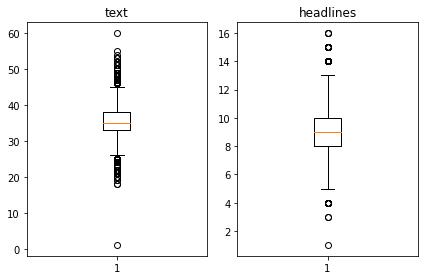

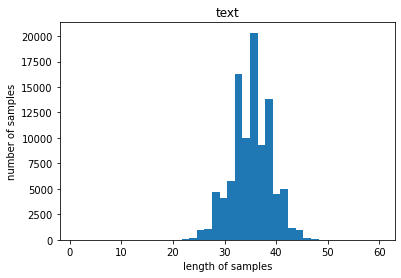

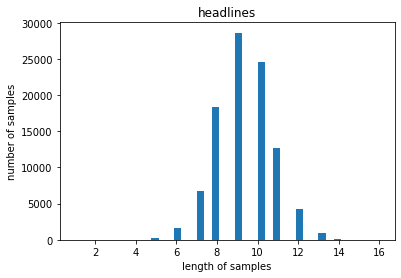

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

### 📦 Boxplot 해석 (가운데 그래프)

#### 왼쪽: Text (본문)

- 대부분의 본문 길이는 **약 30~40단어 사이**
- 위쪽에 점 찍힌 건 **이상치 (60에 가까운 긴 본문)**

#### 오른쪽: Headlines (요약)

- 대부분의 요약은 **8~11단어 사이**
- 12단어 넘는 요약은 **상대적으로 드뭄** → 이상치로 간주됨

---

### 📊 Histogram 해석 (아래쪽 그래프)

#### Text 히스토그램

- **가장 많은 본문**은 약 34~36단어로 구성
- 길이 25~45 단어 사이가 대부분을 차지함
- 데이터 분포가 **정규분포 형태**에 가까움

#### Headlines 히스토그램

- 가장 많은 요약은 **9~10단어**
- 요약 길이는 상대적으로 **더 짧고 집중됨**
- 6~12단어 사이에 **거의 모든 요약이 분포**

---

### **Step 2️⃣ 기준 정하기 (비율 or IQR 기반)**

→ 둘 중 보편적이고 안정적인 방법은 **상위 95% 커버 기준**이에요 (많이 씀)

#### ✅ (1) **비율 기준**
- 상위 N% 이상만 제거 (ex. 상위 95%에 해당하는 길이 초과 샘플 제거)

```python
import numpy as np

text_lengths = [len(x.split()) for x in clean_text]
summary_lengths = [len(x.split()) for x in clean_summary]

text_max_len = int(np.percentile(text_lengths, 95))     # ex. 60
summary_max_len = int(np.percentile(summary_lengths, 95))  # ex. 15
```

#### ✅ (2) **IQR 기준 (통계적 이상치 정의)**
```python
Q1 = np.percentile(text_lengths, 25)
Q3 = np.percentile(text_lengths, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
```



> **IQR (Interquartile Range)** = **Q3 - Q1**

즉,  
- **Q1 (1사분위수)**: 전체 데이터 중 아래 25% 지점  
- **Q3 (3사분위수)**: 전체 데이터 중 위 75% 지점  
- → IQR은 **가운데 50% 데이터의 범위**

---

#### 📊 왜 IQR이 중요한가요?

- **이상치(Outlier)를 판단하는 기준**으로 쓰여요
- IQR 범위 밖에 있는 데이터는 "정상 분포를 벗어난 값"으로 간주합니다

---

#### ✅ 이상치 기준 공식 (암기 팁)

```python
Lower Bound = Q1 - 1.5 * IQR  
Upper Bound = Q3 + 1.5 * IQR
```

- 이 범위를 벗어난 데이터는 **통계적으로 이상치로 간주**
- 예: 텍스트 길이 2개만 혼자 100 단어씩 있을 경우

---

#### 📌 언제 쓰면 좋을까?

| 상황 | IQR 사용? |
|------|-----------|
| 수치형 데이터의 이상치 제거 | ✅ 추천 |
| 텍스트 길이, 요약 길이 정제 | ✅ 매우 유용 |
| 이미지 데이터의 픽셀값 정제 | ❌ (덜 쓰임) |

---

#### ✅ 한 줄 요약

> **IQR = 데이터의 중간 50% 범위를 나타내는 값**이고,  
> **Q1 - 1.5×IQR 또는 Q3 + 1.5×IQR을 벗어나면 통계적 이상치로 간주해 제거할 수 있어요.**


#### (0) lms처럼- 데이터에서 분포 내역을 눈으로 확인하고 결과 확인

In [20]:
text_max_len = 45
headlines_max_len = 12
print('=3')

=3


In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


#### (1) 비율 기준

In [23]:
text_lengths = [len(x.split()) for x in clean_text]
headlines_lengths = [len(x.split()) for x in clean_headlines]

text_max_len = int(np.percentile(text_lengths, 95))     # ex. 60
headlines_max_len = int(np.percentile(headlines_lengths, 95))  # ex. 15

In [24]:
print(f"텍스트의 95% 최대 길이: {text_max_len} 단어")
print(f"헤드라인의 95% 최대 길이: {headlines_max_len} 단어")

텍스트의 95% 최대 길이: 41 단어
헤드라인의 95% 최대 길이: 12 단어


#### (2) IQR 기준 (통계적 이상치 정의)

In [25]:
# 텍스트 IQR 계산
text_Q1 = np.percentile(text_lengths, 25)
text_Q3 = np.percentile(text_lengths, 75)
text_IQR = text_Q3 - text_Q1
text_lower_bound = text_Q1 - 1.5 * text_IQR
text_upper_bound = text_Q3 + 1.5 * text_IQR

In [26]:
# 헤드라인 IQR 계산
head_Q1 = np.percentile(headlines_lengths, 25)
head_Q3 = np.percentile(headlines_lengths, 75)
head_IQR = head_Q3 - head_Q1
head_lower_bound = head_Q1 - 1.5 * head_IQR
head_upper_bound = head_Q3 + 1.5 * head_IQR

In [27]:
print("📌 [텍스트 길이 기준 - IQR]")
print(f"Q1: {text_Q1:.2f}, Q3: {text_Q3:.2f}, IQR: {text_IQR:.2f}")
print(f"허용 범위: {text_lower_bound:.2f} ~ {text_upper_bound:.2f}")

print("\n📌 [헤드라인 길이 기준 - IQR]")
print(f"Q1: {head_Q1:.2f}, Q3: {head_Q3:.2f}, IQR: {head_IQR:.2f}")
print(f"허용 범위: {head_lower_bound:.2f} ~ {head_upper_bound:.2f}")

📌 [텍스트 길이 기준 - IQR]
Q1: 33.00, Q3: 38.00, IQR: 5.00
허용 범위: 25.50 ~ 45.50

📌 [헤드라인 길이 기준 - IQR]
Q1: 8.00, Q3: 10.00, IQR: 2.00
허용 범위: 5.00 ~ 13.00


In [28]:
# 3번 IQR 기준으로 결정

text_max_len = 45
headlines_max_len = 13
print('=3')

=3


In [29]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


### **Step 3️⃣ 기준에 따라 필터링**


- 너무 짧은 것도 제거 (노이즈성)
- 너무 긴 것도 제거 (outlier, padding 낭비)

In [30]:
#IQR 기준으로 최대 길이 초과하는 샘플 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 남은 전체 샘플 수 출력
print('전체 샘플수 :', len(data))

전체 샘플수 : 97863


### Step 4️⃣ 재시각화

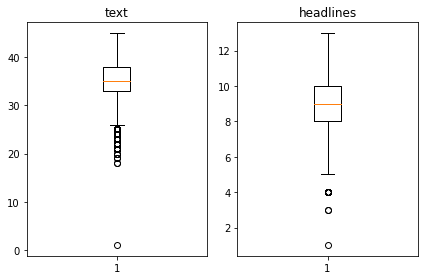

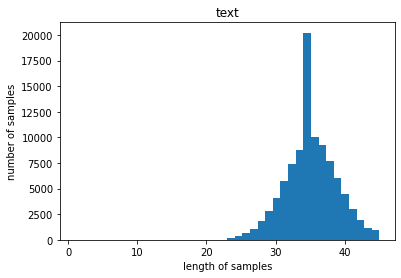

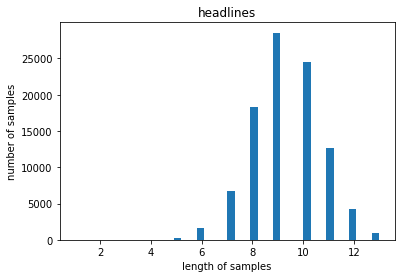

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 45
텍스트의 평균 길이 : 35.063006447789256
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 9.289874620643143


In [31]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

### 너무 짧은 텍스트와 헤드라인발견

✅ **1. 너무 짧은 텍스트**
예: "great!", "nice one" 같은 1~2단어짜리 리뷰

✔️ 문제점:
- 모델이 학습할 정보가 부족해요 (context 없음)
- 의미 없는 스팸성/광고성 문장일 가능성도 높음 (본 사례에선 아님)

💡 보통 텍스트 길이 >= 3 정도는 유지합니다

✅ **2. 너무 짧은 요약문**
예: "true", "good" 같은 요약

✔️ 문제점:
- 추상적인 단어 하나만 있으면 요약 모델이 오답 학습 가능성↑
- 정답이 너무 짧으면 학습 시 손실(loss)이 정확하지 않게 계산되기도 함
💡 보통 요약 길이 >= 2 이상이 좋습니다

#### 유의미한지 아닌지 직접 판단

In [32]:
def print_short_samples(data, min_text_len=20, min_headline_len=4, n=5):
    short_samples = data[
        (data['text'].apply(lambda x: len(x.split()) < min_text_len)) |
        (data['headlines'].apply(lambda x: len(x.split()) < min_headline_len))
    ]
    
    print(f"📌 너무 짧은 텍스트(<{min_text_len}) 또는 헤드라인(<{min_headline_len}) 샘플 수: {len(short_samples)}\n")
    
    for i in range(min(n, len(short_samples))):
        print(f"[샘플 {i+1}]")
        print("📝 텍스트:", short_samples.iloc[i]['text'])
        print("📰 헤드라인:", short_samples.iloc[i]['headlines'])
        print("-" * 50)

In [33]:
print_short_samples(data, min_text_len=20, min_headline_len=4, n=5)

📌 너무 짧은 텍스트(<20) 또는 헤드라인(<4) 샘플 수: 7

[샘플 1]
📝 텍스트: text
📰 헤드라인: headlines
--------------------------------------------------
[샘플 2]
📝 텍스트: african nation angola decriminalised homosexuality parliament removed vices nature provision government also banned discrimination people basis sexual orientation changes come angola parliament adopted first new penal code since gained independence portugal removed provision
📰 헤드라인: angola decriminalises homosexuality
--------------------------------------------------
[샘플 3]
📝 텍스트: foreign nationals working us visas october indians official us report said total indians visas females indians followed chinese visas
📰 헤드라인: of visa holders in are indians us report
--------------------------------------------------
[샘플 4]
📝 텍스트: shahid kapoor said actor one always lonely adding always spotlight people see lonely actors emote inside throw said
📰 헤드라인: as an actor you are always lonely shahid kapoor
--------------------------------------------------
[샘플 

In [34]:
# 헤드라인 길이 리스트
headline_lengths = [len(x.split()) for x in clean_headlines]

# 텍스트 길이 리스트
text_lengths = [len(x.split()) for x in clean_text]

In [35]:
# 헤드라인 길이가 1~4인 샘플 비율
short_headlines = [l for l in headline_lengths if 1 <= l < 4]
short_headline_ratio = len(short_headlines) / len(headline_lengths) * 100

# 텍스트 길이가 1~19인 샘플 비율
short_texts = [l for l in text_lengths if 1 <= l < 20]
short_text_ratio = len(short_texts) / len(text_lengths) * 100

In [36]:
print(f"📌 헤드라인 길이 1~3 단어 사이인 비율: {short_headline_ratio:.2f}%")
print(f"📌 텍스트 길이 1~19 단어 사이인 비율: {short_text_ratio:.2f}%")

📌 헤드라인 길이 1~3 단어 사이인 비율: 0.00%
📌 텍스트 길이 1~19 단어 사이인 비율: 0.01%


#### 너무 짧은 텍스트와 헤드라인 제거

- 샘플 수가 매우 적음 → 데이터 손실거의 없음
- 정보량이 부족함 → 모델 학습에 방해될 수 있음
- boxplot 상에서도 이상치로 판단되는 영역
- 훈련 안정성 및 일반화 향상에 도움

In [37]:
min_text_len = 20
min_headline_len = 4

In [38]:
data = data[data['text'].apply(lambda x: len(x.split()) >= min_text_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) >= min_headline_len)]

# 남은 전체 샘플 수 출력
print('전체 샘플수 :', len(data))

전체 샘플수 : 97856


### 2-2-2. 시작 토큰과 종료 토큰 추가하기 

In [39]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [40]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


### 2-2-3. 훈련 데이터와 테스트 데이터 분리

In [41]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46343 23415 64901 ... 24188 43261 42412]


In [42]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [43]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19571


In [44]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78285
훈련 레이블의 개수 : 78285
테스트 데이터의 개수 : 19571
테스트 레이블의 개수 : 19571


## 2-3.정수 인코딩

### 2-3-1. 단어 집합(vocabulary) 만들기 및 정수 인코딩


**“전처리 후 남기는 데이터 비중은 95%정도가 적당”**  
이건 그냥 관습이 아니라, 실제 **딥러닝 모델 성능과 효율성 사이에서 얻어진 ‘현실적인 균형점’**

---

#### ✅ 왜 빈도 커버율로 기준을 잡을까?

- 자연어에서는 대부분의 정보가 **소수의 자주 등장하는 단어**에 집중되어 있고  
- **희귀 단어 수는 많지만 등장 횟수는 적음**  
→ 이건 **Zipf's Law (지프의 법칙)** 라는 언어 통계 이론과도 연결돼.

> **즉, 전체 단어 빈도의 90%에서 95%는 상위 5%에서 10%의 단어로 설명 가능하다는 것!**

---

#### 💡 그래서 보통은 이렇게 해:

| 빈도 커버 기준 | 사용 이유 | 사용 예 |
|----------------|-----------|---------|
| **90%** | 빠르고 가벼운 모델 필요할 때<br>(ex. 모바일, 실시간) | 챗봇, 감성분석 |
| **95%** | 성능-효율성의 균형점<br>(**가장 많이 사용됨**) | 요약, 번역 |
| **98%+** | 최대한 정보 손실 없이 학습해야 할 때 | 문장 생성, 대화 모델 |


- 🧠 **BERT, GPT 등 사전학습 모델**도 보통 tokenizer가 **vocab size를 30k or 50k**로 제한함  
- 🤖 **KoBERT**: 한국어 기준 8,000~12,000단어  
- 📄 **논문들**: “상위 95% 빈도를 커버하는 단어만 사용”이라는 문구 자주 등장

---

## 📌 결론

> 빈도 기반 커버율 기준은:
> - **95%**가 가장 많이 쓰이는 **표준값**
> - 이보다 낮추면 정보 손실 많고, 높이면 모델 무거움

👉 그래서 95%는 “현실적으로 최적의 sweet spot”이라고 보면 돼.

In [45]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


#### 등장 빈도수가 **6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인**

In [46]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69431
등장 빈도가 5번 이하인 희귀 단어의 수: 45556
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23875
단어 집합에서 희귀 단어의 비율: 65.61334274315507
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.103285825620936


- **등장 빈도 6회 미만인 단어**가 전체 단어 종류의 **65% 이상**이지만,  
  **전체 훈련 데이터에서 실제 사용된 횟수**로 보면 **단 3.09%**밖에 안 됨.
- 그래서 **"이런 자주 안 쓰는 단어는 훈련에 도움이 안 되니까 빼자"**는 전략.
- 이렇게 잘 쓰이지 않는 단어들을 **정수 인코딩에서 제외하고**,  
  모델이 학습하는 단어의 수를 약 **24,000개 정도**로 **제한**.

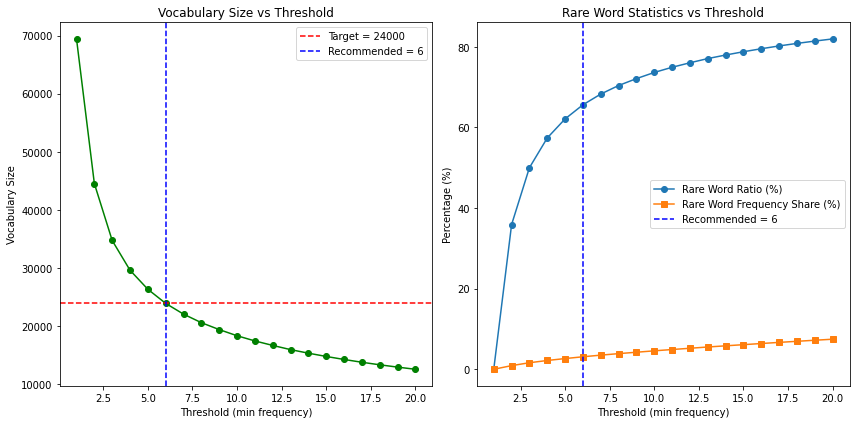

In [47]:
import matplotlib.pyplot as plt

# 단어 등장 빈도수 딕셔너리 추출
word_counts = src_tokenizer.word_counts

# threshold 범위 설정
thresholds = range(1, 21)
vocab_sizes = []         # threshold 이상인 단어들의 수 (단어 집합 크기)
rare_ratios = []         # 희귀 단어 비율 (%)
freq_ratios = []         # 전체 등장 빈도 중 희귀 단어가 차지하는 비율

# 전체 단어 수 및 전체 등장 빈도수
total_cnt = len(word_counts)
total_freq = sum(word_counts.values())

# threshold별 통계 계산
for threshold in thresholds:
    rare_cnt = 0
    rare_freq = 0
    for word, count in word_counts.items():
        if count < threshold:
            rare_cnt += 1
            rare_freq += count
    vocab_sizes.append(total_cnt - rare_cnt)
    rare_ratios.append(rare_cnt / total_cnt * 100)
    freq_ratios.append(rare_freq / total_freq * 100)

# 기준선 설정
target_vocab_size = 24000
recommended_threshold = None
for i, size in enumerate(vocab_sizes):
    if size <= target_vocab_size:
        recommended_threshold = thresholds[i]
        break

# 시각화
plt.figure(figsize=(12, 6))

# subplot 1: Vocabulary Size vs Threshold
plt.subplot(1, 2, 1)
plt.plot(thresholds, vocab_sizes, marker='o', color='green')
plt.axhline(y=target_vocab_size, color='red', linestyle='--', label=f'Target = {target_vocab_size}')
if recommended_threshold:
    plt.axvline(x=recommended_threshold, color='blue', linestyle='--', label=f'Recommended = {recommended_threshold}')
plt.title('Vocabulary Size vs Threshold')
plt.xlabel('Threshold (min frequency)')
plt.ylabel('Vocabulary Size')
plt.legend()

# subplot 2: Rare Word Statistics
plt.subplot(1, 2, 2)
plt.plot(thresholds, rare_ratios, label='Rare Word Ratio (%)', marker='o')
plt.plot(thresholds, freq_ratios, label='Rare Word Frequency Share (%)', marker='s')
if recommended_threshold:
    plt.axvline(x=recommended_threshold, color='blue', linestyle='--', label=f'Recommended = {recommended_threshold}')
plt.title('Rare Word Statistics vs Threshold')
plt.xlabel('Threshold (min frequency)')
plt.ylabel('Percentage (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [48]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
- 현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 **22,000**이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [49]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[42, 4478, 2905, 2356, 1597, 844, 1197, 503, 12193, 1675, 699, 20, 207, 844, 889, 2905, 1166, 2227, 248, 1836, 2949, 7, 92, 1351, 5050, 1675, 1675, 1675, 1675, 1675, 161, 2905, 588, 2949, 15301, 1510, 1194, 3384, 382], [557, 76, 6374, 5137, 62, 1, 1873, 12194, 2023, 20, 23, 1491, 393, 275, 145, 3691, 21, 5137, 734, 264, 124, 3, 13, 37, 6301, 171, 3284, 1401, 16637, 557, 6375], [5, 16, 126, 45, 62, 1, 3319, 8637, 1352, 107, 14218, 759, 5, 4889, 174, 5, 4889, 238, 429, 1544, 77, 19365, 13300, 1678, 1517, 1732, 759, 734, 5, 672, 3032, 619, 18304, 3565, 10452, 2121, 88, 2629]]


### headlines 데이터에 대해서도 동일한 작업을 수행

- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
    -> 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여/ 이는 tar_tokenizer.word_index에 저장
- tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [50]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [51]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29971
등장 빈도가 3번 이하인 희귀 단어의 수: 16920
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13051
단어 집합에서 희귀 단어의 비율: 56.45457275366187
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.185721610639267


- **등장 빈도 4회 미만인 단어**가 전체 단어 종류의 **56% 이상**이지만,  
  **전체 훈련 데이터에서 실제 사용된 횟수**로 보면 **단 3.16%**밖에 안 됨.
- 그래서 **"이런 자주 안 쓰는 단어는 훈련에 도움이 안 되니까 빼자"**는 전략.
- 이렇게 잘 쓰이지 않는 단어들을 **정수 인코딩에서 제외하고**,  
  모델이 학습하는 단어의 수를 약 **13,000개 정도**로 **제한**.

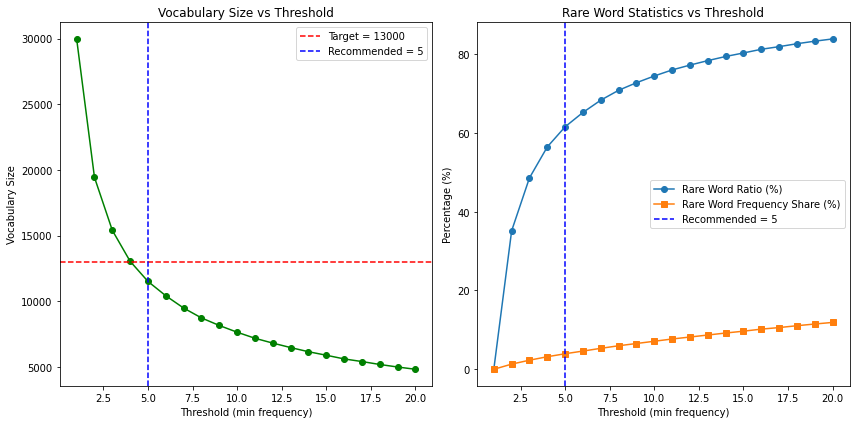

In [52]:
import matplotlib.pyplot as plt

# 단어 등장 빈도수 딕셔너리 추출
word_counts = tar_tokenizer.word_counts

# threshold 범위 설정
thresholds = range(1, 21)
vocab_sizes = []         # threshold 이상인 단어들의 수 (단어 집합 크기)
rare_ratios = []         # 희귀 단어 비율 (%)
freq_ratios = []         # 전체 등장 빈도 중 희귀 단어가 차지하는 비율

# 전체 단어 수 및 전체 등장 빈도수
total_cnt = len(word_counts)
total_freq = sum(word_counts.values())

# threshold별 통계 계산
for threshold in thresholds:
    rare_cnt = 0
    rare_freq = 0
    for word, count in word_counts.items():
        if count < threshold:
            rare_cnt += 1
            rare_freq += count
    vocab_sizes.append(total_cnt - rare_cnt)
    rare_ratios.append(rare_cnt / total_cnt * 100)
    freq_ratios.append(rare_freq / total_freq * 100)

# 기준선 설정
target_vocab_size = 13000
recommended_threshold = None
for i, size in enumerate(vocab_sizes):
    if size <= target_vocab_size:
        recommended_threshold = thresholds[i]
        break

# 시각화
plt.figure(figsize=(12, 6))

# subplot 1: Vocabulary Size vs Threshold
plt.subplot(1, 2, 1)
plt.plot(thresholds, vocab_sizes, marker='o', color='green')
plt.axhline(y=target_vocab_size, color='red', linestyle='--', label=f'Target = {target_vocab_size}')
if recommended_threshold:
    plt.axvline(x=recommended_threshold, color='blue', linestyle='--', label=f'Recommended = {recommended_threshold}')
plt.title('Vocabulary Size vs Threshold')
plt.xlabel('Threshold (min frequency)')
plt.ylabel('Vocabulary Size')
plt.legend()

# subplot 2: Rare Word Statistics
plt.subplot(1, 2, 2)
plt.plot(thresholds, rare_ratios, label='Rare Word Ratio (%)', marker='o')
plt.plot(thresholds, freq_ratios, label='Rare Word Frequency Share (%)', marker='s')
if recommended_threshold:
    plt.axvline(x=recommended_threshold, color='blue', linestyle='--', label=f'Recommended = {recommended_threshold}')
plt.title('Rare Word Statistics vs Threshold')
plt.xlabel('Threshold (min frequency)')
plt.ylabel('Percentage (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
tar_vocab = 13000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2573, 3243, 18, 866, 378, 4, 195, 610, 12, 325], [1, 47, 4534, 95, 15, 18, 29, 514, 35, 7, 1316, 6174], [1, 4680, 2481, 5, 11522, 553, 7, 13, 4681, 31], [1, 2228, 1375, 7, 8745, 16, 1277, 3, 807], [1, 3, 1317, 1711, 16, 29, 1063, 1074, 17, 2790]]
target
decoder  [[2573, 3243, 18, 866, 378, 4, 195, 610, 12, 325, 2], [47, 4534, 95, 15, 18, 29, 514, 35, 7, 1316, 6174, 2], [4680, 2481, 5, 11522, 553, 7, 13, 4681, 31, 2], [2228, 1375, 7, 8745, 16, 1277, 3, 807, 2], [3, 1317, 1711, 16, 29, 1063, 1074, 17, 2790, 2]]


### 2-3-2. 내용이 다 날아가고 토큰만 남은 요약문 샘플들을 찾아서 제거하자!

In [54]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 3]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 3]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78283
훈련 레이블의 개수 : 78283
테스트 데이터의 개수 : 19571
테스트 레이블의 개수 : 19571


- 1의 경우 0, 2의 경우 0이라서 3으로 확장

#### 일반적으로 
- len(sentence) <= 2 또는 <= 3 정도로 필터링합니다.
- sostoken만 있는 건 제거해도 성능에 도움이 됩니다.

## 2-4. 패딩하기

| 개념 | 설명 |
|------|------|
| 패딩(Padding) | 서로 다른 길이의 문장을 **동일한 길이로 맞추는 작업** |
| 목적 | 딥러닝 모델에 한꺼번에 넣기 위해 |
| 방법 | 보통 **숫자 0**을 뒤에 붙여 길이 맞춤 |
| 도구 | Keras의 `pad_sequences()` 함수 사용 |

In [56]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## 3-1. 모델설계

#### 임포트

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 3-1-1. 인코더 설계

In [59]:
# 인코더 설계 시작
embedding_dim = 128 #각 단어는 128차원의 벡터
hidden_size = 256 #각 LSTM 층은 256개의 뉴런을 가지며, 이건 "수용력(capacity)"이자 "기억력"을 결정

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#층을 쌓는것은 모델용량(깊이)를 늘리는 것 

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


###  3-1-2. 디코더 설계

#### 3-1-2-1. 디코더의 출력층 설계

In [60]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값

#### 3-1-2-2. 디코더의 출력층 설계

In [61]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3-2. 어텐션 메커니즘

In [62]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3-3. 모델 훈련하기 

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',          # 저장할 파일명
    monitor='val_loss',                # 어떤 지표를 기준으로 저장할지
    save_best_only=True,               # 가장 좋은 모델만 저장
    save_weights_only=True,            # 모델 전체가 아닌 가중치만 저장
    verbose=1
)

In [66]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    epochs=50,
    callbacks=[es, checkpoint]  #얼리스토핑과 체크포인트 포함 
)

Epoch 1/50
306/306 [==============================] - 43s 124ms/step - loss: 4.6096 - val_loss: 4.4187

Epoch 00001: val_loss improved from inf to 4.41871, saving model to best_model.h5
Epoch 2/50
306/306 [==============================] - 36s 118ms/step - loss: 4.3251 - val_loss: 4.2319

Epoch 00002: val_loss improved from 4.41871 to 4.23191, saving model to best_model.h5
Epoch 3/50
306/306 [==============================] - 36s 119ms/step - loss: 4.1237 - val_loss: 4.0970

Epoch 00003: val_loss improved from 4.23191 to 4.09698, saving model to best_model.h5
Epoch 4/50
306/306 [==============================] - 36s 119ms/step - loss: 3.9597 - val_loss: 3.9804

Epoch 00004: val_loss improved from 4.09698 to 3.98045, saving model to best_model.h5
Epoch 5/50
306/306 [==============================] - 36s 118ms/step - loss: 3.8150 - val_loss: 3.8951

Epoch 00005: val_loss improved from 3.98045 to 3.89511, saving model to best_model.h5
Epoch 6/50
306/306 [==============================] - 

In [67]:
model.load_weights('best_model.h5')

## 3-4. 인퍼런스 모델 구현하기 

#### ✅ 그럼 인퍼런스 모델이란?

> 학습이 끝난 뒤,  
> **실제 문장을 번역하거나 요약할 수 있게 따로 설계한 모델**

#### 💡 왜 따로 만드는 걸까?

- 학습할 땐 **전체 시퀀스를 알고 있으므로** teacher forcing 사용
- 예측할 땐 **앞 단어만 보며 하나씩 생성**해야 해서  
  구조가 달라지기 때문!

In [75]:
#정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
#필요한 3개의 사전 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


### 3-4-1. 인코더 설계 

In [76]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


### 3-4-2. 어텐션 메커니즘을 사용하는 출력층을 설계

In [77]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


### 3-4-3. 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 

> "인퍼런스 단계에서 단어 시퀀스를 완성하는 함수"란,  
> 👉 **디코더를 반복적으로 호출하면서 단어들을 예측해서 하나의 문장으로 이어주는 함수**

In [78]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [81]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

- seq2summary() 함수는 요약문의 정수 시퀀스를 사람이 읽을 수 있는 텍스트로 바꾸는 함수인데,
- 요약문에는 반드시 **시작 토큰 <sos>와 종료 토큰 <eos>**가 포함되어 있다는 점을 고려
    
✅ **목표:**
0은 패딩 → 무시

- `<sos>` → 무시 (출력할 필요 없음)
- `<eos>` → 나오면 거기서 멈추기 (뒤는 필요 없음)

## 4-1. 추상적 요약으로 결과 확인하기 

In [82]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 0):
            continue  # 패딩은 건너뜀
        word = tar_index_to_word[i]  # 정수 → 단어로 변환
        if word == 'sostoken':
            continue  # 시작 토큰은 출력하지 않음
        elif word == 'eostoken':
            break  # 종료 토큰이 나오면 그만
        else:
            temp += word + ' '
    return temp

print('=3')

=3


In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

## 4-2 BLEU수와 Rouge 스코어로 결과 평가하기

### 4-2-1. BLEU (Bilingual Evaluation Understudy) 점수 시각화하기

BLEU는 **예측한 문장(요약/번역)** 이 **정답 문장과 얼마나 단어 수준에서 일치하는가**를 측정하는 정밀도 기반 지표야.

> 점수 범위: **0.0 ~ 1.0** (보통은 **0% ~ 100%로 표현**)

#### 🔹 일반적인 BLEU 점수 해석 기준표

| BLEU 점수 | 해석 | 실제 의미 |
|-----------|------|------------|
| **> 0.60** | 훌륭함 (Excellent) | 거의 사람이 쓴 것처럼 정확한 요약 |
| **0.40 ~ 0.60** | 좋음 (Good) | 핵심 정보 정확히 포함, 어순도 유사 |
| **0.20 ~ 0.40** | 보통 (Acceptable) | 키워드 위주로 맞았지만 어색한 구조 |
| **0.10 ~ 0.20** | 낮음 (Weak) | 단어는 일부 맞았지만 정보 부족 |
| **< 0.10** | 매우 낮음 (Poor) | 완전히 다른 요약, 또는 엉뚱한 결과 |
| **= 0.0** | 실패 | 정답과 겹치는 단어조차 없음 😥 |

> ✅ **주의**: BLEU는 단어 순서와 형태에 아주 민감해서, **사람이 보기엔 괜찮은 요약도 낮게 나올 수 있음**


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import numpy as np

bleu_scores = []
for i in range(50, 100):
    reference = seq2headlines(decoder_input_test[i]).split()
    candidate = decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).split()
    score = sentence_bleu([reference], candidate, weights=(0.5, 0.5))
    bleu_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(range(50, 100), bleu_scores, marker='o', color='blue')
plt.title("BLEU Score per Sample")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()


#### 🔹 축 설명

- **x축 (Sample Index)**: 테스트 샘플 번호 (`50~100`번까지 확인)
- **y축 (BLEU Score)**: 각 샘플의 BLEU 점수 (0.0 ~ 1.0 사이)

---

#### 🔍 해석 요약

1. **BLEU가 0인 경우가 많다**  
   → 예측 요약이 **정답 요약과 거의 겹치지 않는다**는 뜻.  
   (n-gram이 매치되지 않음)

2. **간헐적으로 0.2 ~ 0.4 이상 나오는 경우 존재**  
   → 이건 예측 요약이 정답 요약과 **단어 선택이나 순서가 유사했음**을 의미함.  
   예:  
   - Sample 70 → BLEU 0.45 (상당히 좋은 편)
   - Sample 60, 80, 99 → 0.3 이상

3. **BLEU 점수의 전반적인 평균이 낮음**  
   → 전체적으로 요약 성능이 BLEU 기준으로는 높지 않음.  
   (하지만 요약 모델은 BLEU보단 **ROUGE로 성능 평가**하는 게 일반적임)

---

#### ⚠️ 참고

- **BLEU는 짧은 문장에 약하다**: 실제 요약이 짧고 간결하면 BLEU가 과하게 낮게 나올 수 있음.
- 따라서 **ROUGE-L (Longest Common Subsequence 기반)** 평가도 같이 보는 게 좋음!  

### ✅ 4-2-2. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

ROUGE는 BLEU와 다르게 **정답 요약을 기준으로 예측이 얼마나 잘 커버했는지**, 즉 **재현율(Recall)** 기반으로 평가

> 문서 요약에서는 BLEU보다 ROUGE가 더 많이 사용

---

#### 🔹 ROUGE의 종류

| 종류 | 측정 방식 | 해석 포인트 |
|------|------------|-------------|
| **ROUGE-1** | unigram(단어 단위) recall | 핵심 단어가 잘 들어있는지 |
| **ROUGE-2** | bigram(두 단어 조합) recall | 문장 연결, 표현력이 반영됐는지 |
| **ROUGE-L** ✅ | LCS (Longest Common Subsequence) 기반 | **문장 구조, 흐름**까지 유사한지 |

> 📌 **ROUGE-L**은 전체 문장의 **흐름, 순서**까지 고려해서 자연어 요약 평가에 가장 적합한 지표 중 하나

---

#### 🔹 일반적인 ROUGE 점수 해석 (특히 ROUGE-L)

| ROUGE 점수 | 해석 | 실제 의미 |
|------------|------|------------|
| **> 0.60** | 매우 좋음 | 문장 구조와 내용이 거의 일치 |
| **0.40 ~ 0.60** | 좋음 | 핵심 흐름과 단어 다수 포함 |
| **0.25 ~ 0.40** | 보통 | 키워드 위주 포함, 일부 틀림 |
| **0.10 ~ 0.25** | 약함 | 정보 누락 많음 |
| **< 0.10** | 나쁨 | 주제 불일치, 거의 다른 문장 |
| **= 0.0** | 실패 | 겹치는 단어, 구조 없음 |

---

#### ✅ BLEU vs ROUGE 핵심 비교

| 항목 | BLEU | ROUGE |
|------|------|--------|
| 기반 | **Precision** (정밀도) | **Recall** (재현율) |
| 목적 | 얼마나 "정확히 따라 했는가" | 얼마나 "잘 커버했는가" |
| 민감성 | 단어 순서에 민감 | 구조 흐름까지 반영 (특히 ROUGE-L) |
| 요약 적합성 | 보통 약간 불리 | **요약엔 더 적합** ✅ |

#### 환경설정

In [85]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=d0e15bc6d7259a223aea1edf90c30282509071522cebc24873d19f4de7f6488f
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.



✅ Average BLEU: 4.68
✅ Average ROUGE-1: 21.83
✅ Average ROUGE-2: 5.29
✅ Average ROUGE-L: 19.64


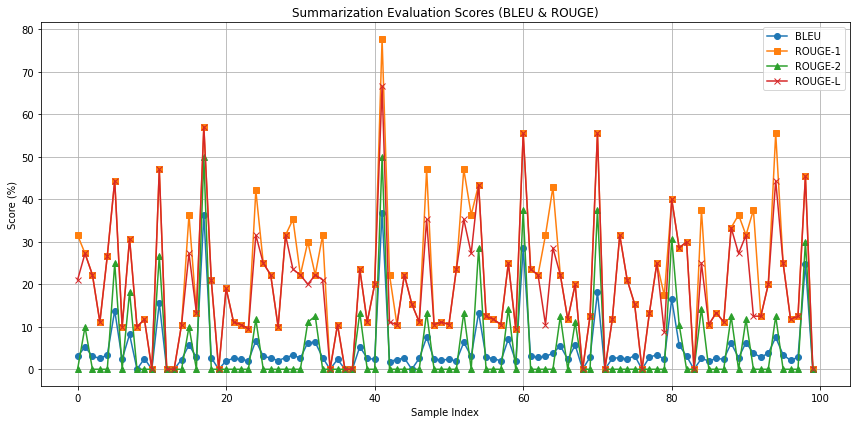

In [86]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

# 평가 결과 저장 리스트
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# 평가 대상 수 설정 (ex: 테스트셋 앞 100개)
num_samples = 100

for i in range(num_samples):
    # 원문, 실제 요약, 예측 요약
    original_text = seq2text(encoder_input_test[i])
    reference = seq2headlines(decoder_input_test[i])
    hypothesis = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

    # BLEU (tokenization 필요)
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)
    bleu_scores.append(bleu * 100)  # 백분율화

    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    rouge1_scores.append(scores['rouge1'].fmeasure * 100)
    rouge2_scores.append(scores['rouge2'].fmeasure * 100)
    rougeL_scores.append(scores['rougeL'].fmeasure * 100)

# 평균 점수 출력
print(f"\n✅ Average BLEU: {sum(bleu_scores)/num_samples:.2f}")
print(f"✅ Average ROUGE-1: {sum(rouge1_scores)/num_samples:.2f}")
print(f"✅ Average ROUGE-2: {sum(rouge2_scores)/num_samples:.2f}")
print(f"✅ Average ROUGE-L: {sum(rougeL_scores)/num_samples:.2f}")

# 📊 시각화
plt.figure(figsize=(12, 6))
plt.plot(bleu_scores, label='BLEU', marker='o')
plt.plot(rouge1_scores, label='ROUGE-1', marker='s')
plt.plot(rouge2_scores, label='ROUGE-2', marker='^')
plt.plot(rougeL_scores, label='ROUGE-L', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Score (%)')
plt.title('Summarization Evaluation Scores (BLEU & ROUGE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1. **BLEU 점수 (파란색)** : 정답 요약과 예측 요약 간의 n-gram 정확도 (정확히 겹치는 단어 비율)
   - 전체적으로 낮고 (평균 **4.68%**) 대부분 **0~10% 이하**  
   - 단어 순서까지 따지므로 **요약이 짧거나 표현이 조금만 달라도 점수가 낮게 나옴**  
   - **짧은 요약엔 불리함** (요약 모델에서는 BLEU가 참고용임)
   > BLEU 낮음 | 표현이 정답과 많이 다름 (단어/순서 모두 다를 수 있음)

2. **ROUGE-1 (주황색)** : 단어 수준의 recall (단일 단어 얼마나 겹쳤는가)
   - 평균 **21.83%** → 정답 요약과 **단어 수준에서 20% 정도 겹침**  
   - 일부 샘플은 **50~70%까지 높게 나옴** → 꽤 적절한 요약 있음
   >  ROUGE-1 보통 | 중요한 단어는 어느 정도 포함함

3. **ROUGE-2 (초록색)** : bigram (2단어 연속쌍) 기준 recall 
   - 평균 **5.29%** → bigram 기준으론 일치율 낮음  
   - 이건 **짧거나 표현이 다른 경우** 생김  
   - 모델이 정답과 같은 표현 순서를 잘 만들지 못하고 있음
   >  ROUGE-2 낮음 | 문장 흐름 (연속된 단어) 재현은 아직 부족

4. **ROUGE-L (빨간색)** :  LCS (최장 공통 부분 수열) 기반 유사도 → 문장 구조 반영
   - 평균 **19.64%** → 문장 구조(문맥 흐름)는 약간 반영  
   - 일부는 **70%까지 매우 유사**  
   - 이 지표는 **seq2seq+attention 모델의 구조적 요약 품질을 가장 잘 반영**
   > ROUGE-L 일부 높음 | 구조적으로 유사한 요약도 있음


### 4-1-2. ROUGE-L 기준 상위, 하위 top5 요약 결과를 리뷰

In [91]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

smoother = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

results = []

for i in range(50, 100):
    reference = seq2headlines(decoder_input_test[i])
    candidate = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

    # BLEU
    bleu = sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoother)

    # ROUGE
    scores = scorer.score(reference, candidate)

    results.append({
        'index': i,
        'bleu': bleu,
        'rougeL': scores['rougeL'].fmeasure
    })

# 정렬 기준: ROUGE-L
top5 = sorted(results, key=lambda x: x['rougeL'], reverse=True)[:5]
bottom5 = sorted(results, key=lambda x: x['rougeL'])[:5]

for name, samples in [("Top-5 by ROUGE-L", top5), ("Bottom-5 by ROUGE-L", bottom5)]:
    print(f"\n== {name} ==")
    for sample in samples:
        i = sample['index']
        print(f"[{i}] BLEU: {sample['bleu']:.4f} | ROUGE-L: {sample['rougeL']:.4f}")
        print("Original:", seq2text(encoder_input_test[i]))
        print("Real Summary:", seq2headlines(decoder_input_test[i]))
        print("Predicted:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
        print("-" * 60)



== Top-5 by ROUGE-L ==
[60] BLEU: 0.2847 | ROUGE-L: 0.5556
Original: delhi police planning buy least body cameras record criminal activities comes delhi commission women chairperson swati maliwal wrote delhi police commissioner patnaik suggesting officers duty wear body cameras commission also said funds pilot project taken nirbhaya fund 
Real Summary: delhi police to get body cameras to record criminal activity 
Predicted:  delhi police to get cctv cameras in delhi
------------------------------------------------------------
[70] BLEU: 0.1492 | ROUGE-L: 0.5556
Original: man us state missouri dressed every year santa claus arrested molesting year old girl girl illustrated ordeal series drawings special interview trained forensic investigators man later admitted also accused inappropriate sexual contact children 
Real Summary: santa arrested for molesting year old girl in us 
Predicted:  us man arrested for raping minor girl in us
-------------------------------------------------------

#### ✅ Top-5 (ROUGE-L 높은 경우)의 특징

| 인덱스 | ROUGE-L | 공통 특징 요약 |
|--------|----------|----------------|
| 60     | 0.5556   | 핵심 명사구 중심 요약 성공 ("body cameras", "Delhi police")  
| 70     | 0.5556   | 사건 요약 중심 키워드 일치 ("Santa arrested", "molesting girl")  
| 98     | 0.4545   | 인물 발언의 요약 성공 ("Shah said", "Opposition", "PM every day")  
| 94     | 0.4444   | 인용문 유지 (SRK의 인용문 요약 반영)  
| 54     | 0.4348   | 사건의 결과 요약 잘 반영 ("jump in front of train", "suicide pact")  

🧠 **핵심 패턴:**
- **주어 + 동사 + 핵심 키워드** 구조 보존
- 실제 요약과 **유사한 문장 구조** 유지
- **고유명사**, **행동 묘사**, **인용문 유지** 등 비교적 쉬운 포맷

---

#### ❌ Bottom-5 (ROUGE-L 0.0) 특징

| 인덱스 | ROUGE-L | 문제점 요약 |
|--------|----------|-------------|
| 68     | 0.0000   | 주제 벗어난 엉뚱한 예측 ("Black Panther" → "Game of Thrones")  
| 71     | 0.0000   | 예측 문장이 실제 요약과 완전히 무관 ("tax"→"demonetisation")  
| 76     | 0.0000   | "electric vehicle" 요약이 없고, 엉뚱한 브랜드명 등장  
| 83     | 0.0000   | "condoms" → "beer beer beer" 완전 nonsensical  
| 99     | 0.0000   | 실제 요약은 "housing policy", 예측은 "govt approves free..."  

🧠 **실패 패턴:**
- **핵심 주제 파악 실패**
- **비정상적 문장 생성** 또는 **의미 없음**
- **정답과 키워드 불일치**
- 유사도 측정에서 **LCS가 전혀 존재하지 않음**

---

#### 📊 결과 요약 분석

| 항목 | 상위 5개 | 하위 5개 |
|------|---------|----------|
| **키워드 일치** | 명확히 반영됨 | 엉뚱한 키워드 또는 누락  
| **문장 구조** | 비교적 정돈됨 | 비문/구조 오류 많음  
| **모델 출력 품질** | 인용, 주어-동사 관계 잘 포착 | 언어 모델링 실패 or 표현력 부족  
| **BLEU 점수** | 일부 낮지만 ROUGE-L 높음 | 대부분 0점  

---

### 📌 정리 및 원인 분석

#### 🔹 Top-5의 성공 요인:
- 명확한 사건/주어/행동이 있는 문장
- 뉴스 요약의 전형적인 구조 (ex. "[사건] → [결과]")
- 어텐션 메커니즘이 핵심 단어에 잘 집중

#### 🔸 Bottom-5의 실패 요인:
- 원문이 길고 복잡해서 **정보가 분산됨**
- 핵심 키워드/문장이 아닌 **주변 정보**에 주목
- 모델의 언어 생성 능력이 약해져 **의미 불명 문장 생성**
- 일부 예측은 **문맥 상관 없이 반복 단어 출력**


------

# Step 5. Summa를 이용해서 추출적 요약해보기

## 5-1. Summa를 이용해서 추출적 요약 

### 5-1-1. 기존 데이터 그대로 해보기

- 시퀀스 모델의 rogue점수 탑 5와 하위 5를 기준으로 결과 비교해보기

In [97]:
from summa.summarizer import summarize

# Top-5와 Bottom-5 인덱스
top5_indices = [60, 70, 98, 94, 54]
bottom5_indices = [68, 71, 76, 83, 99]

for label, indices in [('Top-5', top5_indices), ('Bottom-5', bottom5_indices)]:
    print(f"\n== {label} by ROUGE-L (Summa) ==")
    for i in indices:
        original = seq2text(encoder_input_test[i])
        real = seq2headlines(decoder_input_test[i])
        predicted = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))

        try:
            summa_summary = summarize(original, words=10)
        except ValueError:
            summa_summary = "(⚠️ Not enough sentences)"

        print(f"\n[{i}]")
        print("Original:", original)
        print("Real Summary:", real)
        print("Predicted Summary:", predicted)
        print("Summa Summary:", summa_summary)
        print("-" * 60)



== Top-5 by ROUGE-L (Summa) ==

[60]
Original: delhi police planning buy least body cameras record criminal activities comes delhi commission women chairperson swati maliwal wrote delhi police commissioner patnaik suggesting officers duty wear body cameras commission also said funds pilot project taken nirbhaya fund 
Real Summary: delhi police to get body cameras to record criminal activity 
Predicted Summary:  delhi police to get cctv cameras in delhi
Summa Summary: 
------------------------------------------------------------

[70]
Original: man us state missouri dressed every year santa claus arrested molesting year old girl girl illustrated ordeal series drawings special interview trained forensic investigators man later admitted also accused inappropriate sexual contact children 
Real Summary: santa arrested for molesting year old girl in us 
Predicted Summary:  us man arrested for raping minor girl in us
Summa Summary: 
-----------------------------------------------------------

📌 주의할 점
- summa는 내부적으로 **문장을 기준으로 분리**하고, **핵심 문장을 추출**하는 구조
- 그런데 지금 데이터는 원래 문장 부호가 없고, 콤마나 마침표가 없는 **원시 문장 덩어리(전처리로 인한)**

→ 그래서 문장 단위로 나누기가 어려워서, 제대로 작동하지 않음

#### 원본 데이터 다시 로드

In [110]:
import urllib.request
import pandas as pd

# 웹에서 데이터 다운로드
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
urllib.request.urlretrieve(url, filename="news_summa_2.csv")

# 데이터 로드
data_summa = pd.read_csv("news_summa_2.csv", encoding="iso-8859-1")

# 데이터 확인
print(data_summa.head())

                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  


### 5-1-2. 재시도 (불러온 데이터로 시도)

- 시퀀스 모델의 rogue점수 탑 5와 하위 5를 기준으로 결과 비교해보기

In [114]:
top5_indices = [60, 70, 98, 94, 54]
bottom5_indices = [68, 71, 76, 83, 99]

# 요약 결과 출력
for label, indices in [('Top-5', top5_indices), ('Bottom-5', bottom5_indices)]:
    print(f"\n== {label} by ROUGE-L (Summa, No Preprocessing) ==")
    for i in indices:
        original = data_summa.loc[i, 'text']
        real_summary = data_summa.loc[i, 'headlines']

        try:
            summary = summarize(original, ratio=0.2)
            if not summary.strip():
                summary = summarize(original, words=20)
        except ValueError:
            summary = "(⚠️ 요약 불가: 너무 짧음)"

        print(f"[{i}]")
        print("Original:", original)
        print("Real Summary:", real_summary)
        print("Summa Summary:", summary)
        print("-" * 60)


== Top-5 by ROUGE-L (Summa, No Preprocessing) ==
[60]
Original: The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1. The clarification came amid speculations that a full Budget may be presented during the session. The government recently assigned Piyush Goyal temporary additional charge of the Finance and Corporate Affairs ministries in the absence of Arun Jaitley, who is in the US for treatment.
Real Summary: Govt to present Interim Budget, not full Budget on February 1
Summa Summary: The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1.
------------------------------------------------------------
[70]
Original: Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, i

- 시퀀스 모델의 rogue 점수 top5로 비교 분석하려고 했으나, 전처리 등의 이유로 **인덱스가 동일하지 않음**
- 따라서, 새로 summa 기준으로 점수를 매기고 탑5와 하위 5의 기준에 따라 재평가 진행 필요 


## 5-2. Summa의 BLEU 및 ROUGE 점수 계산

✅ Average BLEU     : 2.92
✅ Average ROUGE-1 : 32.22
✅ Average ROUGE-2 : 11.65
✅ Average ROUGE-L : 26.83


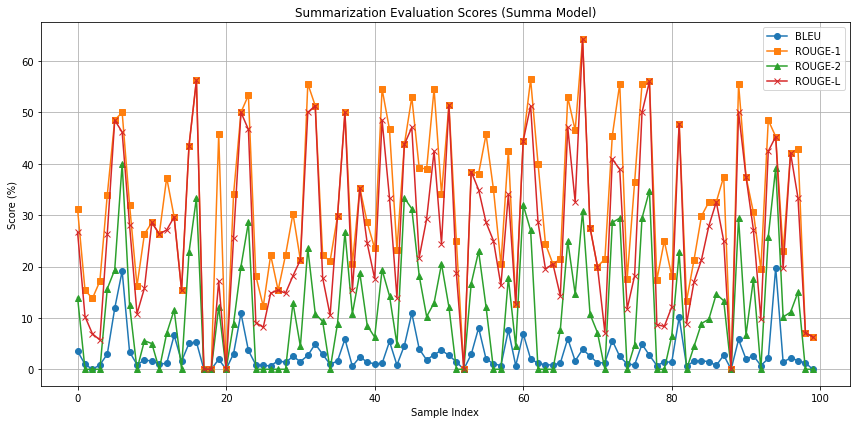

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 데이터 불러오기
data_summa = pd.read_csv("summa_100_samples.csv")

# BLEU 및 ROUGE 준비
smoother = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# 점수 저장 리스트
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# 평가
for _, row in data_summa.iterrows():
    reference = str(row['headlines'])
    hypothesis = str(row['predicted'])

    # BLEU 점수
    bleu = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoother)
    bleu_scores.append(bleu * 100)

    # ROUGE 점수
    scores = scorer.score(reference, hypothesis)
    rouge1_scores.append(scores['rouge1'].fmeasure * 100)
    rouge2_scores.append(scores['rouge2'].fmeasure * 100)
    rougeL_scores.append(scores['rougeL'].fmeasure * 100)

# 평균 출력
print(f"✅ Average BLEU     : {sum(bleu_scores)/len(bleu_scores):.2f}")
print(f"✅ Average ROUGE-1 : {sum(rouge1_scores)/len(rouge1_scores):.2f}")
print(f"✅ Average ROUGE-2 : {sum(rouge2_scores)/len(rouge2_scores):.2f}")
print(f"✅ Average ROUGE-L : {sum(rougeL_scores)/len(rougeL_scores):.2f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(bleu_scores, label='BLEU', marker='o')
plt.plot(rouge1_scores, label='ROUGE-1', marker='s')
plt.plot(rouge2_scores, label='ROUGE-2', marker='^')
plt.plot(rougeL_scores, label='ROUGE-L', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Score (%)')
plt.title('Summarization Evaluation Scores (Summa Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 📊 **Summa 모델 결과 요약**
| 평가 지표      | 평균 점수 | 의미 |
|----------------|------------|------------------------|
| **BLEU**       | 2.92%      | 거의 문장 단위 복원이 안 됨 |
| **ROUGE-1**    | 32.22%     | 단어 단위 중첩은 꽤 있음 |
| **ROUGE-2**    | 11.65%     | 2-gram 중첩은 낮음 |
| **ROUGE-L**    | 26.83%     | 문장 구조 일부 유사 |

---

### 🧠 **Summa 요약 방식의 특성상 나타나는 현상 분석**

####  1. **BLEU 점수 낮음 (평균 2.92%)**
- Summa는 "원문에서 가장 중요한 문장 1~2개"를 그대로 추출.
- 하지만 정답 요약은 종종 **새롭게 구성된 문장**으로, 추출 요약과 **어휘 일치율이 낮음**.
- 따라서 BLEU가 낮은 것은 당연한 결과.
- 즉, **Summa는 재작성 성능은 없지만 핵심정보 복원 측면에서는 강점**이 있음.

####  2. **ROUGE-1 점수는 상대적으로 높음 (평균 32.22%)**
- 단어 단위 중첩은 높게 나오는 편 → 추출된 문장이 실제 요약과 **비슷한 단어 집합**을 공유.
- 이는 Summa가 중요 키워드를 **중심으로 한 문장 추출**을 잘 하고 있다는 뜻.
- 다만 문장 전체 길이에 비해 **중요 단어 비중이 작을 경우** 점수가 낮아질 수 있음.

####  3. **ROUGE-2 낮음 (11.65%)**
- 2-gram 중첩이 낮다는 것은, 예측 요약 내 **연속된 단어 쌍이 실제 요약과 다르다**는 것.
- 추출 문장이 곧장 요약이 되기 어렵고, 정답은 종종 **자연스럽게 재구성된 문장**이기 때문.
- **단어 조합 수준에서의 문장 재구성이 필요**하다는 시사점.

####  4. **ROUGE-L 평균은 26.83%로 중간**
- LCS 기반이라 문장 구조와 순서를 일부 반영.
- 실제 요약과 구조가 **부분적으로 일치**함을 의미하지만, 완벽하진 않음.
- Summa는 **원문 구조에 의존한 결과를 내기 때문에**, 정답 요약 구조와 다르면 점수 하락.

---

###  **그래프 해석 포인트**

- BLEU 점수는 전체적으로 낮은 편이며 대부분 5점 이하. 이는 **정답 요약과 어순·어휘 일치율이 낮다**는 것.
- ROUGE-1과 ROUGE-L은 40~60%까지 나오는 구간도 많음. → **중요 문장은 잘 뽑는 편**.
- ROUGE-2의 변동폭은 크며, 특정 기사에서만 높은 점수가 나옴. → 일부 문장에서만 문맥 흐름이 맞음.

---

###  **종합 인사이트**
- Summa는 전반적으로 **정확한 문장 재작성에는 취약**하지만, **핵심 정보가 포함된 문장 추출에는 강점**.
- 문장 생성이 아닌 "문장 선택" 기반이므로, **재구성·어순정렬이 필요한 정답 요약과는 불일치**가 존재.
- 따라서, BLEU와 ROUGE-2보다는 **ROUGE-1, ROUGE-L 같은 단어 기반/문장 기반 평가 지표**가 더 적합.


In [174]:
# 데이터 불러오기
data_summa = pd.read_csv("summa_100_samples.csv")

# 평가 함수 준비
smoother = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 점수 계산 및 저장
results = []
for idx, row in data_summa.iterrows():
    reference = str(row['headlines'])
    hypothesis = str(row['predicted'])

    bleu = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoother)
    rougeL = scorer.score(reference, hypothesis)['rougeL'].fmeasure

    results.append({
        'index': idx,
        'bleu': bleu * 100,
        'rougeL': rougeL * 100,
        'text': row['text'],
        'reference': reference,
        'summary': hypothesis
    })

# 상위 5개 / 하위 5개
top_bleu = sorted(results, key=lambda x: x['bleu'], reverse=True)[:5]
top_rouge = sorted(results, key=lambda x: x['rougeL'], reverse=True)[:5]

bottom_bleu = sorted(results, key=lambda x: x['bleu'])[:5]
bottom_rouge = sorted(results, key=lambda x: x['rougeL'])[:5]

# 출력 함수
def display_top(name, top_list, score_type):
    print(f"\n== 🏆 Top-5 by {score_type.upper()} ==")
    for i, item in enumerate(top_list, 1):
        print(f"\n[{item['index']}] ⬅️ Rank {i}")
        print(f"📊 {score_type.upper()} Score: {item[score_type]:.2f}")
        print(f"📌 Original   : {item['text']}")
        print(f"✅ Reference  : {item['reference']}")
        print(f"✏️  Predicted  : {item['summary']}")
        print("-" * 80)

def display_bottom(name, bottom_list, score_type):
    print(f"\n== ❌ Bottom-5 by {score_type.upper()} ==")
    for i, item in enumerate(bottom_list, 1):
        print(f"\n[{item['index']}] ⬇️ Rank {i}")
        print(f"📊 {score_type.upper()} Score: {item[score_type]:.2f}")
        print(f"📌 Original   : {item['text']}")
        print(f"✅ Reference  : {item['reference']}")
        print(f"✏️  Predicted  : {item['summary']}")
        print("-" * 80)

# 결과 출력
display_top("BLEU", top_bleu, "bleu")
display_bottom("BLEU", bottom_bleu, "bleu")

display_top("ROUGE-L", top_rouge, "rougeL")
display_bottom("ROUGE-L", bottom_rouge, "rougeL")



== 🏆 Top-5 by BLEU ==

[94] ⬅️ Rank 1
📊 BLEU Score: 19.78
📌 Original   : While speaking about winning awards for his films, Shah Rukh Khan said, "If I don't get an award, that award is at a loss." "Sometimes, the prestige of an award increases when I receive it," the actor jokingly added. Shah Rukh further said that he was "extremely ambitious" but in a "fair manner". 
✅ Reference  : If I don't get an award, that award is at loss: SRK
✏️  Predicted  : While speaking about winning awards for his films, Shah Rukh Khan said, "If I don't get an award, that award is at a loss." "Sometimes, the prestige of an award increases when I receive it," the actor jokingly added.
--------------------------------------------------------------------------------

[6] ⬅️ Rank 2
📊 BLEU Score: 19.11
📌 Original   : India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-

| 지표 | 평균 점수 | Top-5 특징 | Bottom-5 특징 |
|------|------------|-------------|----------------|
| **BLEU** | 2.92 | 참조 요약(reference)의 단어들이 요약(predicted)에 많이 포함됨 | 요약이 `nan`이거나 길이 매우 짧음 (공백 포함) |
| **ROUGE-L** | 26.83 | 원문에서 핵심 문장 그대로 추출됨 (extractive) | `nan`, 혹은 정답과 구조/중심 내용이 완전히 불일치 |

---

### ✅ BLEU 기반 Top-5 요약 분석

#### 🔍 공통 특징
- **단어 일치율**이 높음: reference와 predicted가 동일하거나 매우 유사한 단어를 공유
- 종종 **원문 전체 문장 중 일부**를 추출해 참조 요약과 겹치는 구조를 가짐
- BLEU는 **정확한 단어 순서와 n-gram 일치**를 평가하므로, 이러한 정형적 추출에 유리

#### 🎯 요약 잘 되는 경우 (BLEU 기준)
- 정답 요약(reference)이 원문의 한 문장과 거의 일치할 때
- 단일 사건, 명확한 사실 전달형 뉴스:  
  예:  
  > ✅ Reference: *India get all out for 92*  
  > ✏️ Predicted: *India recorded their lowest ODI total in New Zealand after getting all out for 92...*

---

### ❌ BLEU 기반 Bottom-5 요약 분석

#### 🔍 공통 특징
- **예측이 비어 있음** (`nan`)
- 또는 요약된 문장이 핵심 요약 내용과 상관없는 **비주요 정보** 포함

#### 🤔 문제점
- BLEU는 단어 수준의 정합성(n-gram 매칭)에만 민감 → 내용이 비슷하더라도 **표현 다르면 점수 낮음**
- 따라서 **표현 다양성이 허용되는 경우엔 부정확**한 판단 가능

---

### ✅ ROUGE-L 기반 Top-5 요약 분석

#### 🔍 공통 특징
- **문장 길이도 비슷하고** 핵심 문장 또는 키워드가 거의 동일하게 추출됨
- 대부분 원문 문장을 그대로 가져오거나 압축형 요약으로 구성됨
- ROUGE는 **순서가 유지된 토큰의 겹침 (Longest Common Subsequence)**을 보기 때문에 유사도 높게 평가됨

#### 예:
> ✅ Reference: *Swine flu outbreak kills 76 in Rajasthan*  
> ✏️ Predicted: *...swine flu outbreak has killed 76 people this year in Rajasthan.*

➡️ 핵심 숫자 정보 + 장소 정보가 유지됨 → 높은 ROUGE

---

### ❌ ROUGE-L 기반 Bottom-5 요약 분석

#### 🔍 공통 특징
- `nan`, 또는 원문 일부만 잘린 채 문맥이 전혀 반영되지 않은 예측
- 핵심 사건, 주체, 장소, 수치 등 요약에 필요한 **핵심 정보가 결여**

#### 문제 예시:
> ✅ Reference: *I think the opposition even dreams about me: PM Modi*  
> ✏️ Predicted: `nan`  
> → ROUGE는 정보 일치율이 기준이기 때문에 `0점`


## 5-4. Summa 요약 모델 특성 정리

| 항목 | 설명 |
|------|------|
| **요약 방식** | **추출적 요약** (extractive summarization) |
| **장점** | 원문 내 핵심 문장을 뽑아내는 데 능숙함<br>객관적 사실/숫자/이름 등 정리된 문장에 강함 |
| **단점** | 문장 재구성이 불가능 (요약 제목처럼 재구성된 요약에 약함)<br>중요치 않은 문장이 추출될 수도 있음 |
| **BLEU 적합도** | 중복 단어가 많을 경우 유리하나 표현이 다르면 점수 낮음 |
| **ROUGE 적합도** | 추출식 모델에 매우 적합. 핵심 문장 보존 여부에 정확함 |

---

#### 📌 어떤 상황에 사용하면 좋은가?

| 용도 | 적합 여부 | 설명 |
|------|-----------|------|
| **뉴스 헤드라인 생성** | ⚠️ 제한적 | 문장 구조 재구성이 필요하기 때문에 abstractive 요약이 더 적합 |
| **문서 요약** | ✅ 매우 적합 | 긴 문서에서 핵심 문장 추출이 필요할 때 유용 |
| **질의응답 기반 문서 요약** | ⚠️ 미흡 | 질문에 대한 핵심 정보 재구성 능력 부족 |
| **법률 문서, 보고서 요약** | ✅ 유리 | 명확한 핵심 정보가 있는 문서에서 효과적 |

---

#### ✅ 결론

- **BLEU 점수 Top 사례는** 추출된 문장이 단어 수준에서 참조 요약과 매우 유사할 때 점수가 높음
- **ROUGE 점수 Top 사례는** 정보 중심적이며 구조 일치율이 높은 경우에 우수
- **Bottom 사례는** 대부분 요약 실패 (`nan`)이거나, 핵심 정보를 담지 못한 예측

> 🔍 **Summa 요약 모델은 "문서 요약"에는 강하고, "요약문 생성"에는 약한** 전형적인 추출형 summarize

# Step 6. 추출적 요약과 추론적 요약 결과 비교하기

## 6-1.환경설정

### 6-1-1. 예측결과가 저장된 파일 생성하기

In [118]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [123]:
data.to_csv('filtered_data.csv', index=False)  # 필터링 결과 따로 저장

In [156]:
data = pd.read_csv("filtered_data.csv")  # 전처리된 Seq2Seq용
data_summa = pd.read_csv("news_summa_2.csv")  # 원본 그대로

In [157]:
# 샘플 수 설정 (예: 100개)
sample_size = 100

# 예측 결과 저장
predicted_seq_list = []
for i in range(sample_size):
    pred = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    predicted_seq_list.append(pred)

# 기존 DataFrame 앞에서 sample_size 개수만큼 슬라이싱
data_sampled = data.iloc[:sample_size].copy()
data_sampled['predicted'] = predicted_seq_list

In [158]:
data_sampled.to_csv("seq2seq_100_samples.csv", index=False)

In [159]:
from summa.summarizer import summarize

# 샘플 수 설정
sample_size = 100

# 데이터 앞에서 sample_size 개만 복사
data_summa_sampled = data_summa.iloc[:sample_size].copy()

# 요약 결과 저장
predicted_summa_list = []

for text in data_summa_sampled['text']:
    try:
        summary = summarize(text, ratio=0.2)
        if not summary.strip():  # 비었으면 fallback
            summary = summarize(text, words=25)
    except ValueError:
        summary = "(⚠️ 요약 불가: 너무 짧음)"
    predicted_summa_list.append(summary)

# 예측 결과를 컬럼으로 저장
data_summa_sampled['predicted'] = predicted_summa_list


In [160]:
data_summa_sampled.to_csv("summa_100_samples.csv", index=False)

### 6-1-2. 원문 유사도 기반 자동 매칭

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tqdm import tqdm

# 데이터 로드
summa_df = pd.read_csv("summa_100_samples.csv")     # 원본
seq2seq_df = pd.read_csv("seq2seq_100_samples.csv") # 전처리 후

# TF-IDF 벡터화 (시간 절약 위해 상위 N개로 줄이기)
summa_texts = summa_df['text'].tolist()
seq_texts = seq2seq_df['text'].tolist()

vectorizer = TfidfVectorizer().fit(summa_texts + seq_texts)
summa_tfidf = vectorizer.transform(summa_texts)
seq_tfidf = vectorizer.transform(seq_texts)

# 유사도 계산
similarity_matrix = cosine_similarity(seq_tfidf, summa_tfidf)

# 각 seq2seq 문장과 가장 유사한 summa 문장 인덱스 찾기
best_matches = similarity_matrix.argmax(axis=1)
match_scores = similarity_matrix.max(axis=1)

# 병합용 데이터프레임 생성
matched_rows = []
for i, best_idx in enumerate(best_matches):
    matched_rows.append({
        'seq_index': i,
        'summa_index': best_idx,
        'similarity': match_scores[i],
        'text_seq': seq_texts[i],
        'text_summa': summa_texts[best_idx],
        'headlines': summa_df.loc[best_idx, 'headlines'],
        'predicted_summa': summa_df.loc[best_idx, 'predicted'],
        'predicted_seq2seq': seq2seq_df.loc[i, 'predicted']
    })

matched_df = pd.DataFrame(matched_rows)

# 유사도 기준 필터링 (너무 다른 건 제외)
matched_df = matched_df[matched_df['similarity'] > 0.6]  # 유사도 threshold 조정 가능

# 결과 확인
print(f"✅ Matched {len(matched_df)} pairs with similarity > 0.6")
display(matched_df[['similarity', 'headlines', 'predicted_summa', 'predicted_seq2seq']].head())


✅ Matched 98 pairs with similarity > 0.6


,similarity,headlines,predicted_summa,predicted_seq2seq
0,0.915697,upGrad learner switches to career in ML & Al w...,The program and upGrad's 360-degree career sup...,indians data data card to be data of lakh
1,0.936485,Delhi techie wins free food from Swiggy for on...,Users get one CRED coin per rupee of bill paid...,kuldeep yadav once will not be spinner in ind...
2,0.888258,New Zealand end Rohit Sharma-led India's 12-ma...,The match witnessed India getting all out for ...,startup makes electric car that can be made in
3,0.824300,Aegon life iTerm insurance plan helps customer...,"Also, customers have options to insure against...",woman claims woman refuses to kiss her to gir...
4,0.866592,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,uber ceo appoints highest ever female ceo of


In [15]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 데이터 로드
df = pd.read_csv("matched_samples_80plus.csv")

# 평가 준비
smoother = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 결과 저장
results = []

for _, row in df.iterrows():
    reference = str(row['ground_truth'])

    # ✅ Seq2Seq
    seq_pred = str(row['seq2seq_summary'])
    bleu_seq = sentence_bleu([reference.split()], seq_pred.split(), smoothing_function=smoother)
    rouge_seq = scorer.score(reference, seq_pred)['rougeL'].fmeasure

    # ✅ Summa
    summa_pred = str(row['summa_summary'])
    bleu_summa = sentence_bleu([reference.split()], summa_pred.split(), smoothing_function=smoother)
    rouge_summa = scorer.score(reference, summa_pred)['rougeL'].fmeasure

    results.append({
        'seq2seq_bleu': bleu_seq * 100,
        'seq2seq_rougeL': rouge_seq * 100,
        'summa_bleu': bleu_summa * 100,
        'summa_rougeL': rouge_summa * 100,
        'reference': reference,
        'seq2seq_summary': seq_pred,
        'summa_summary': summa_pred
    })

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv("evaluation_results_matched.csv", index=False)
print("✅ 점수 계산 완료. 'evaluation_results_matched.csv'로 저장되었습니다.")


✅ 점수 계산 완료. 'evaluation_results_matched.csv'로 저장되었습니다.


#### 유사도 80%이상만 따로 필터링하여 파일생성

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# 데이터 불러오기
data_summa = pd.read_csv("summa_100_samples.csv")
data_seq2seq = pd.read_csv("seq2seq_100_samples.csv")

# 텍스트 전처리 (문자열로 변환)
summa_texts = data_summa['text'].astype(str).tolist()
seq2seq_texts = data_seq2seq['text'].astype(str).tolist()

# TF-IDF 벡터라이저 학습
vectorizer = TfidfVectorizer().fit(summa_texts + seq2seq_texts)

# 결과 저장 리스트
matched = []

# 유사도 계산
for i, text_seq in tqdm(enumerate(seq2seq_texts), total=len(seq2seq_texts)):
    vec_seq = vectorizer.transform([text_seq])
    
    max_sim = 0
    best_match = None

    for j, text_summa in enumerate(summa_texts):
        vec_summa = vectorizer.transform([text_summa])
        sim = cosine_similarity(vec_seq, vec_summa)[0][0]

        if sim >= 0.80:
            matched.append({
                'seq2seq_index': i,
                'summa_index': j,
                'similarity': sim,
                'seq2seq_text': text_seq,
                'summa_text': text_summa,
                'seq2seq_summary': data_seq2seq.loc[i, 'predicted'],
                'summa_summary': data_summa.loc[j, 'predicted'],
                'ground_truth': data_summa.loc[j, 'headlines']
            })
            break  # 가장 유사한 하나만 저장


100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


In [17]:
matched_df = pd.DataFrame(matched)
matched_df.to_csv("matched_samples_80plus.csv", index=False)
print(f"🔍 {len(matched_df)} pairs matched with similarity >= 0.80")


🔍 90 pairs matched with similarity >= 0.80


In [181]:
matched_df.sample(10)

,seq2seq_index,summa_index,similarity,seq2seq_text,summa_text,seq2seq_summary,summa_summary,ground_truth
15,18,18,0.863073,days threatened step post congress mlas contin...,Days after he threatened to step down from his...,man arrested for hoax bomb threat to be held,NaN,How long can I tolerate Congress leaders' pots...
31,35,35,0.863216,twenty seven year old mohammed mahuwala arrest...,Twenty-seven-year-old Mohammed Mahuwala was ar...,bank of bank fraud in mumbai get crore from bank,Twenty-seven-year-old Mohammed Mahuwala was ar...,Man arrested for cheating Amazon of â¹30 lakh...
67,73,74,0.836315,german automaker volkswagen group retained car...,German automaker Volkswagen Group has retained...,bjp mla shares video of his rally in wb,"Volkswagen's sales, including its MAN and Scan...","Volkswagen retains top spot in global sales, b..."
48,54,55,0.878375,actress mishti featured manikarnika queen jhan...,"Actress Mishti, who has featured in 'Manikarni...",delhi man kills yr old son in front of his son,"Actress Mishti, who has featured in 'Manikarni...",Kangana made fake promises to cast: 'Manikarni...
56,62,63,0.868248,year old writer turned job offer claiming bull...,"A 22-year-old writer turned down a job offer, ...",shahid alia to miss shahid for the next week in,"A 22-year-old writer turned down a job offer, ...",Woman rejects job after CEO bullies her in int...
21,24,24,0.888474,indian oil corporation wednesday said looking ...,Indian Oil Corporation on Wednesday said it's ...,bjp leader slaps man who tried to remove him,The US had in November granted a six-month wai...,Indian Oil looking for annual deal to buy crud...
43,48,48,0.899351,railway police rescued woman travelling train ...,Railway police has rescued a woman travelling ...,players to be sold for champions trophy at mu...,Railway police has rescued a woman travelling ...,Railway police rescues woman with leg stuck in...
61,67,68,0.848536,yami gautam felicitated border security force ...,Yami Gautam was felicitated by Border Security...,we are not pm modi on rafale deal with india,Yami Gautam was felicitated by Border Security...,Yami Gautam felicitated by BSF for performance...
28,32,32,0.915308,silvia grecco year old brazilian mother narrat...,"Silvia Grecco, a 56-year-old Brazilian mother ...",man kills wife after he kills wife over affair,"Silvia Grecco, a 56-year-old Brazilian mother ...",Brazilian mother narrates football matches to ...
87,95,97,0.884044,shiv sena chief uddhav thackeray asked bjp dec...,Shiv Sena chief Uddhav Thackeray has asked the...,rbi denies reports of banks to file accounts,Shiv Sena chief Uddhav Thackeray has asked the...,Decide about an alliance within 15 days: Uddha...


## 6-2. BLEU 지표와 Rouge 지표로 비교하기 

### 6-2-1. 모델 평가 지표 산출 및 비교 과정

In [8]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 파일 로드
df = pd.read_csv("matched_samples_80plus.csv")

# 평가 도구 준비
smoother = SmoothingFunction().method1
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 평가
bleu_seq, rouge_seq = [], []
bleu_sum, rouge_sum = [], []

for _, row in df.iterrows():
    gt = str(row['ground_truth'])
    pred_seq = str(row['seq2seq_summary'])
    pred_summa = str(row['summa_summary'])

    # BLEU & ROUGE for Seq2Seq
    bleu_seq.append(sentence_bleu([gt.split()], pred_seq.split(), smoothing_function=smoother) * 100)
    rouge_seq.append(scorer.score(gt, pred_seq)['rougeL'].fmeasure * 100)

    # BLEU & ROUGE for Summa
    bleu_sum.append(sentence_bleu([gt.split()], pred_summa.split(), smoothing_function=smoother) * 100)
    rouge_sum.append(scorer.score(gt, pred_summa)['rougeL'].fmeasure * 100)

# 데이터프레임에 추가
df['seq2seq_bleu'] = bleu_seq
df['seq2seq_rougeL'] = rouge_seq
df['summa_bleu'] = bleu_sum
df['summa_rougeL'] = rouge_sum

# 저장
df.to_csv("evaluation_results_matched.csv", index=False)
print("✅ evaluation_results_matched.csv 저장 완료")


✅ evaluation_results_matched.csv 저장 완료


In [9]:
df.sample(10)

,seq2seq_index,summa_index,similarity,seq2seq_text,summa_text,seq2seq_summary,summa_summary,ground_truth,seq2seq_bleu,seq2seq_rougeL,summa_bleu,summa_rougeL
55,61,62,0.891929,senior priest vatican handled cases sexual abu...,A senior priest at the Vatican who handled cas...,congress has no place in karnataka assembly c...,A senior priest at the Vatican who handled cas...,Vatican priest handling sex abuse cases quits ...,0.000000,0.000000,1.183306,28.571429
70,76,77,0.858641,government officials wednesday said swine flu ...,Government officials on Wednesday said that a ...,great brand in india hottest great great prog...,Government officials on Wednesday said that a ...,Swine flu outbreak kills 76 in Rajasthan,2.398030,12.500000,2.716638,56.000000
85,92,94,0.871978,speaking winning awards films shah rukh khan s...,While speaking about winning awards for his fi...,sonam shares pic with sonam kareena from sonam,While speaking about winning awards for his fi...,"If I don't get an award, that award is at loss...",0.000000,0.000000,19.783692,45.283019
44,49,49,0.890469,us tuesday began returning asylum seekers mexi...,The US on Tuesday began returning asylum seeke...,turkey prez erdo out of war in turkey over tu...,The US on Tuesday began returning asylum seeke...,US begins sending back asylum seekers to Mexico,0.000000,0.000000,3.679437,24.390244
5,5,5,0.827979,pakistani singer rahat fateh ali khan denied r...,Pakistani singer Rahat Fateh Ali Khan has deni...,elon musk shares picture with girlfriend shar...,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...,0.000000,0.000000,11.856660,48.484848
65,71,72,0.910161,bjp national secretary rahul sinha wednesday a...,BJP National Secretary Rahul Sinha on Wednesda...,banks will not be in note ban on demonetisation,BJP National Secretary Rahul Sinha on Wednesda...,Come armed with sticks for PM Modi's rally in ...,1.718263,9.090909,5.585149,40.909091
88,96,98,0.800447,bjp president amit shah wednesday took dig opp...,BJP President Amit Shah on Wednesday took a di...,uk visa returns to india after years,He said the Opposition is thinking about leadi...,"Grand alliance, if wins, will see a new PM eve...",0.000000,0.000000,1.230069,7.142857
13,15,15,0.855988,louis vuitton owner lvmh makes high end bevera...,"Louis Vuitton owner LVMH, which makes high-end...",hc orders govt to monitor school model in blu...,"Louis Vuitton owner LVMH, which makes high-end...",Louis Vuitton owner to stockpile 4 months of w...,2.046892,17.391304,5.047069,43.478261
51,57,58,0.940282,pakistan captain sarfaraz ahmed banned four ma...,"Pakistan captain Sarfaraz Ahmed, who has been ...",mahindra is the best friend to be ambani,"Pakistan captain Sarfaraz Ahmed, who has been ...","Banned for 4 matches, Sarfaraz shares 'log hai...",0.000000,0.000000,7.603431,34.042553
72,78,79,0.850643,jet airways wednesday denied directed ge capit...,Jet Airways on Wednesday denied it was directe...,doctors protest outside hospital over protest...,"Further, three aircraft have been temporarily ...",Jet Airways denies being told to ground aircraft,0.000000,0.000000,1.462806,8.333333


### 6-2-2. BLEU 지표와 Rouge 지표 기준으로 top 5 출력 

In [11]:
import pandas as pd

# 평가 파일 불러오기
df = pd.read_csv("evaluation_results_matched.csv")

# 출력 함수
def display_top5(df, sort_col, title):
    print(f"\n== 🏆 Top-5 by {title.upper()} ==")
    top5 = df.sort_values(by=sort_col, ascending=False).head(5)
    for i, row in top5.iterrows():
        print(f"\n[{row['seq2seq_index']}] ⬅️ Index")
        print(f"📊 Seq2Seq BLEU: {row['seq2seq_bleu']:.2f} | ROUGE-L: {row['seq2seq_rougeL']:.2f}")
        print(f"📊 Summa   BLEU: {row['summa_bleu']:.2f} | ROUGE-L: {row['summa_rougeL']:.2f}")
        print(f"📌 Ground Truth (headline): {row['ground_truth']}")
        print(f"🟢 Seq2Seq Summary       : {row['seq2seq_summary']}")
        print(f"🔵 Summa Summary         : {row['summa_summary']}")
        print(f"📝 Source Text (cleaned) : {row['seq2seq_text']}")
        print("-" * 100)

# 각 점수 기준 상위 5개 출력
display_top5(df, "seq2seq_bleu", "Seq2Seq BLEU")
display_top5(df, "seq2seq_rougeL", "Seq2Seq ROUGE-L")
display_top5(df, "summa_bleu", "Summa BLEU")
display_top5(df, "summa_rougeL", "Summa ROUGE-L")



== 🏆 Top-5 by SEQ2SEQ BLEU ==

[64] ⬅️ Index
📊 Seq2Seq BLEU: 3.30 | ROUGE-L: 25.00
📊 Summa   BLEU: 1.21 | ROUGE-L: 14.29
📌 Ground Truth (headline): Qatar to invest $200 million in Airtel Africa
🟢 Seq2Seq Summary       :  steel to be first largest businesses in years
🔵 Summa Summary         : Airtel Africa, the holding company for Airtel's operations in 14 African countries, is preparing for an initial public offering.
📝 Source Text (cleaned) : airtel wednesday said qatar sovereign wealth fund qatar investment authority invest million primary equity issuance airtel africa india second largest telecom operator africa unit recently raised billion six investors airtel africa holding company airtel operations african countries preparing initial public offering
----------------------------------------------------------------------------------------------------

[97] ⬅️ Index
📊 Seq2Seq BLEU: 2.78 | ROUGE-L: 12.50
📊 Summa   BLEU: 0.00 | ROUGE-L: 6.25
📌 Ground Truth (headline): Demonetisation 

### 🔹 1. **Seq2Seq 모델 분석 (BLEU & ROUGE-L 기준)**

#### ✅ 잘하는 경우 (Top-5 기준)
- **BLEU 점수 Top**:  
  - `Seq2Seq Summary`는 여전히 의미적으로 크게 벗어난 경우가 많지만, 일부 키워드(예: steel, crore 등)가 참조 요약(GT)과 겹치면서 BLEU 점수 확보.
  - 예시: “Qatar to invest $200 million in Airtel Africa” → “steel to be first largest businesses in years” → 연관성은 떨어지지만 구조 유사성.

- **ROUGE-L Top**:  
  - 텍스트 길이나 구조적인 유사성에 따른 점수 상승이 많음.
  - 즉, 모델이 **문장 형태를 부분적으로 모방**하는 경우 ROUGE-L이 높음.
  - **문맥은 거의 무관한 경우도 있음.**

#### ❌ 공통 문제점
- 예측이 **의미적으로 엉뚱**하거나 전혀 관계없는 요약 생성.
- BLEU 점수가 상대적으로 높더라도, **정보 재현이 부정확**.
- 예: "pm modi could be kept in india swaraj" ←→ "Karanvir Bohra detained in Russia"

---

### 🔹 2. **Summa 모델 분석 (BLEU & ROUGE-L 기준)**

#### ✅ 잘하는 경우 (Top-5 기준)
- **BLEU & ROUGE-L 점수 모두 높음**
  - 요약 내용이 **원문 중 핵심 문장 그대로 추출**된 경우 → 아주 높은 점수 획득
  - 예: "Rahat Fateh Ali Khan denies getting notice..." → 요약 그대로 인용

- ROUGE-L이 높은 경우
  - 문장 길이도 충분하고, 핵심 내용이 빠지지 않음.
  - 예: `"Yami Gautam was felicitated..."`, `"Swine flu outbreak has killed 76..."`

#### ❌ 공통 문제점
- 추출형 모델 특성상 **문장 자체는 정확하지만, 요약의 압축력이 낮음**.
- BLEU가 낮은 경우는 GT가 **짧은 헤드라인형 문장**일 때, 길이 차이로 인한 n-gram 불일치 때문.


### 6-2-3. 지표 시각화

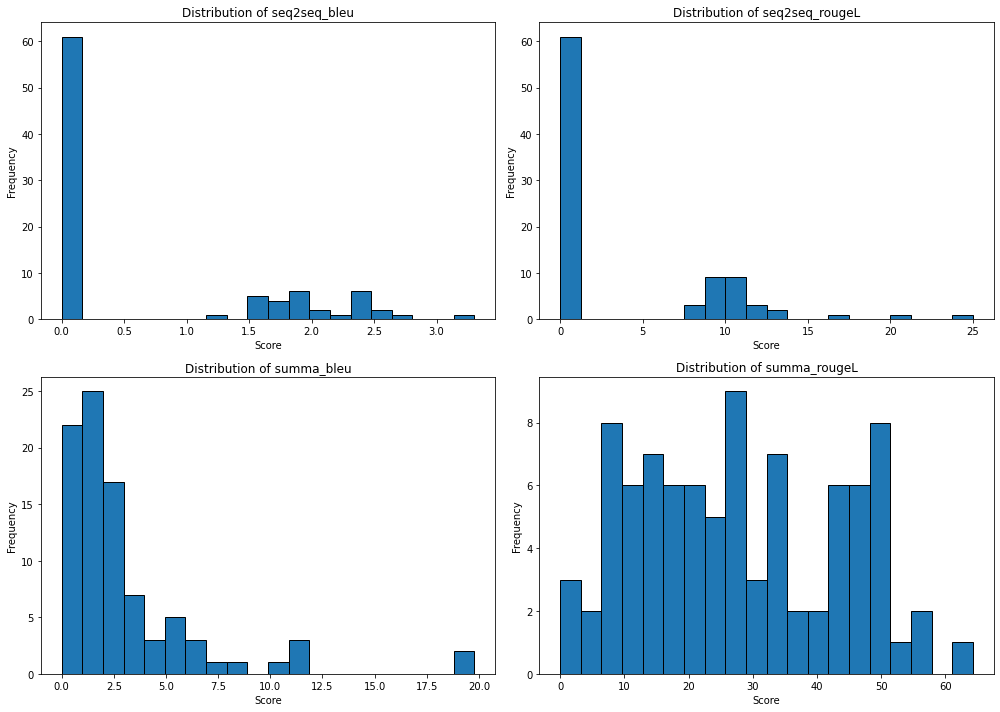

In [12]:
# 시각화 대상 점수
metrics = ["seq2seq_bleu", "seq2seq_rougeL", "summa_bleu", "summa_rougeL"]

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].hist(df[metric], bins=20, edgecolor='black')
    axes[i].set_title(f"Distribution of {metric}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


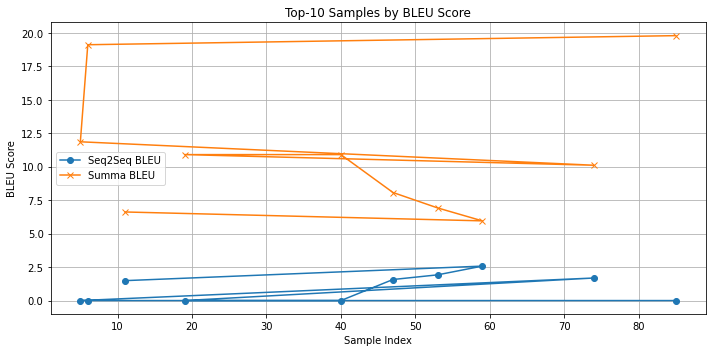

In [13]:
# BLEU 점수 평균 기준으로 상위 10개
df['bleu_avg'] = (df['seq2seq_bleu'] + df['summa_bleu']) / 2
top10_bleu = df.sort_values(by='bleu_avg', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.plot(top10_bleu.index, top10_bleu["seq2seq_bleu"], label="Seq2Seq BLEU", marker='o')
plt.plot(top10_bleu.index, top10_bleu["summa_bleu"], label="Summa BLEU", marker='x')
plt.title("Top-10 Samples by BLEU Score")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


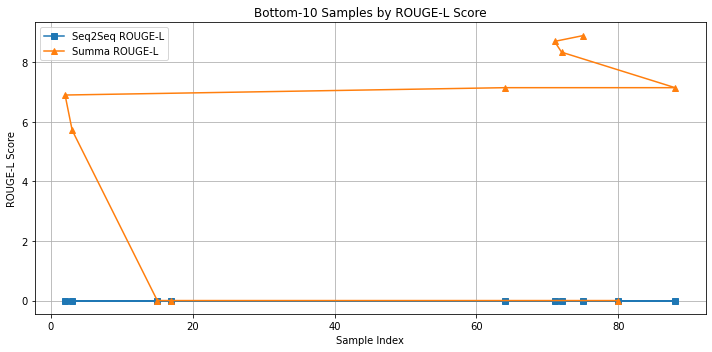

In [14]:
# ROUGE-L 점수 평균 기준으로 하위 10개
df['rougeL_avg'] = (df['seq2seq_rougeL'] + df['summa_rougeL']) / 2
bottom10_rouge = df.sort_values(by='rougeL_avg').head(10)

plt.figure(figsize=(10, 5))
plt.plot(bottom10_rouge.index, bottom10_rouge["seq2seq_rougeL"], label="Seq2Seq ROUGE-L", marker='s')
plt.plot(bottom10_rouge.index, bottom10_rouge["summa_rougeL"], label="Summa ROUGE-L", marker='^')
plt.title("Bottom-10 Samples by ROUGE-L Score")
plt.xlabel("Sample Index")
plt.ylabel("ROUGE-L Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6-3. 정보 보존 평가 (Keyword Coverage Evaluation)

### 6-3-1. 정보 보존 평가란?

 **모델 평가 방법 중 하나**로, 특히 **요약(Summarization) 모델의 "정보 보존 능력"**을 평가하는 **내용 중심의 정량 평가 방법**

---

| 구분 | 설명 |
|------|------|
| **평가 대상** | Seq2Seq (추상적 요약), Summa (추출적 요약) 모델 |
| **평가 기준** | 정답 요약(Ground Truth)과의 유사도 외에, **원문에서 추출된 핵심 키워드**가 요약에 얼마나 포함되었는지 |
| **핵심 지표** | 🔑 핵심 단어 포함 수 / 포함 비율 |
| **비교 목적** | 생성된 요약이 **중요 정보(핵심 키워드)를 잘 담고 있는가**를 BLEU/ROUGE와 **보완적으로** 평가 |

---

#### 🧠 왜 중요한가?

기존 BLEU/ROUGE 평가는:

- ✅ 문장 구조나 단어 순서 기준
- ❌ 내용의 핵심 정보 포함 여부까지는 못 봄

> → 하지만 **뉴스 요약, 리포트 요약**처럼 중요한 정보가 빠지면 **요약의 목적 자체가 무의미**해지기 때문에,  
> 이런 **"정보 포함률 기반" 평가**는 **실제 품질을 판단하는 데 매우 유용**해.

---

#### ✅ 용어로 정리하면

| 평가 이름 | 설명 |
|-----------|------|
| **Keyword Inclusion Evaluation** | 핵심 단어 몇 개 포함됐는지 |
| **Content Fidelity Check** | 원문의 중요한 내용이 보존되었는지 평가 |
| **Abstractive Recall Metric** | 추상 요약에서 원문 키워드 포함 비율 (Recall 기반) |

---

#### 🚀 요약하자면

이건 모델 자체에 대한 평가고,  
BLEU/ROUGE는 **형태와 문장 유사도 중심**,  
이 방식은 **정보 보존 및 핵심 내용 전달력 중심** 평가

그래서 이 둘을 **보완적으로** 같이 쓰면 **요약 모델의 성능을 더 입체적으로 이해**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(text, n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = vectorizer.fit_transform([text])
    scores = zip(vectorizer.get_feature_names_out(), tfidf.toarray()[0])
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)
    return [word for word, _ in ranked[:n]]


#### ✅ TF-IDF란?

> 문서 집합(corpus)에서 **어떤 단어가 특정 문서에 얼마나 중요한지를 수치로 표현**하는 방법이야.

TF-IDF 점수가 높을수록,
- 해당 단어는 그 문서에 **자주 등장**하면서,
- 전체 문서들에서는 **드물게 등장**한다는 의미!

---

#### ✅ 수식 요약

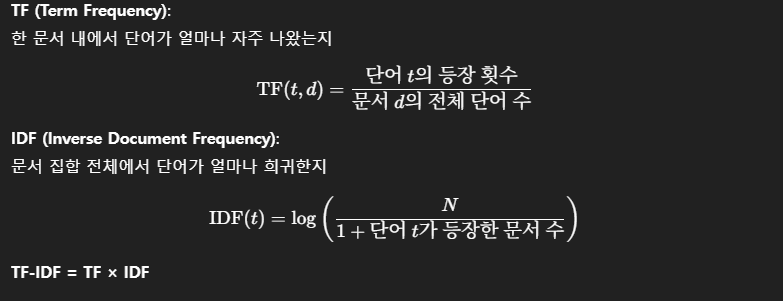

---

#### ✅ 직관적 예시

```python
corpus = [
    "dog cat dog",
    "dog mouse",
    "cat mouse mouse"
]
```

- `dog`는 문서 1개에서 자주 나오지만 전체 문서에서 자주 나와서 IDF가 낮아짐.
- `mouse`는 2개의 문서에 있지만, 특정 문서에서 많이 나와서 그 문서 내에서는 TF가 높음.

→ **TF는 로컬 중요도**, **IDF는 글로벌 희귀성**이라 생각하면 됨.

---

#### ✅ 핵심 단어 추출에 쓰는 이유?

> 요약을 평가할 때 **원문에서 중요한 단어가 요약에 잘 포함되었는지** 보려면,
> 먼저 "원문에서 중요한 단어"를 뽑아야 함 → 이때 **TF-IDF 기반 상위 단어**를 핵심 단어로 씀.

### 6-3-2. Keyword Inclusion Evaluation

> 원문에서 추출한 핵심 단어(Keyword) 중
> 요약문에 포함된 개수를 측정하여,
> 중요 정보가 얼마나 잘 보존됐는지를 평가하는 방법

In [28]:
def count_keyword_hits(text, keywords):
    return sum(1 for kw in keywords if kw in text.split())

### 6-3-3. Content Fidelity Check

> 요약에 핵심 단어가 몇 개 이상 들어 있으면,
> 원문 내용을 충실히 반영했다"고 판단하는 단순한 규칙 기반 평가
>  - 정성적 → 간단히 keyword hit 수 >= 3이면 True

📌 예시 정의
핵심 키워드 5개를 추출했다고 가정

- 요약문 내에 그중 3개 이상 포함되면 → ✅ True (충실히 반영됨)
- 아니면 → ❌ False (내용 누락됨)

#### ✅ 왜 이 기준이 유용할까?

| 장점 | 설명 |
|------|------|
| 직관적 | 딱 봐도 핵심이 포함됐는지 판단 가능 |
| 정성적 평가에 근접 | 사람이 읽고 "괜찮다" 느낄 수준을 수치로 근사 |
| 보완적 | BLEU/ROUGE 점수가 낮아도, 핵심이 포함됐다면 괜찮을 수 있음 |

---

#### 🧠 요약

- 핵심 키워드 **3개 이상 포함**이면 → **내용 보존 신뢰할 수 있음**
- 간단하지만 실용적인 기준
- 특히 **추상적 요약**의 품질 평가에 보조적으로 탁월

In [29]:
def is_content_faithful(text, keywords, threshold=3):
    return count_keyword_hits(text, keywords) >= threshold

### 6-3-4. Abstractive Recall Metric (포함된 키워드 비율)

- **추상 요약(abstractive summary)**이 원문에서 추출한 핵심 키워드들을 얼마나 많이 포함했는지를 비율로 나타낸 평가 지표
- "요약이 원문의 중요한 내용을 얼마나 놓치지 않고 담았는가?" 를 정량적으로 측정하는 방식

In [30]:
def keyword_recall(text, keywords):
    if not keywords:
        return 0.0
    return count_keyword_hits(text, keywords) / len(keywords)

### 6-3-5. 적용

In [36]:
keyword_hits_seq2seq = []
keyword_hits_summa = []
recall_seq2seq = []
recall_summa = []
fidelity_seq2seq = []
fidelity_summa = []

for _, row in df.iterrows():
    keywords = extract_keywords(str(row['seq2seq_text']), n=5)

    seq_pred = str(row['seq2seq_summary'])
    sum_pred = str(row['summa_summary'])

    keyword_hits_seq2seq.append(count_keyword_hits(seq_pred, keywords))
    keyword_hits_summa.append(count_keyword_hits(sum_pred, keywords))

    recall_seq2seq.append(keyword_recall(seq_pred, keywords))
    recall_summa.append(keyword_recall(sum_pred, keywords))

    fidelity_seq2seq.append(is_content_faithful(seq_pred, keywords))
    fidelity_summa.append(is_content_faithful(sum_pred, keywords))

df['keyword_hits_seq2seq'] = keyword_hits_seq2seq
df['keyword_hits_summa'] = keyword_hits_summa
df['recall_seq2seq'] = recall_seq2seq
df['recall_summa'] = recall_summa
df['fidelity_seq2seq'] = fidelity_seq2seq
df['fidelity_summa'] = fidelity_summa


### 6-3-6. 결과 시각화

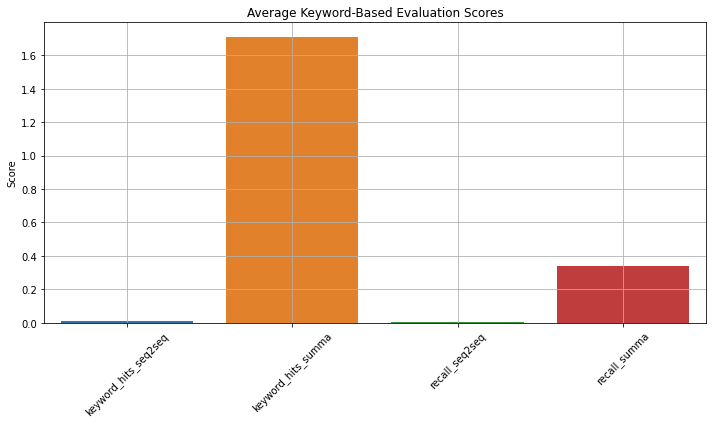

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화를 위한 주요 지표
metrics = ['keyword_hits_seq2seq', 'keyword_hits_summa', 'recall_seq2seq', 'recall_summa']
averages = {metric: df[metric].mean() for metric in metrics}

# 평균 점수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=list(averages.keys()), y=list(averages.values()))
plt.title("Average Keyword-Based Evaluation Scores")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
top5 = df.sort_values(by='recall_seq2seq', ascending=False).head(5)
bottom5 = df.sort_values(by='recall_seq2seq', ascending=True).head(5)

display_cols = [
    'recall_seq2seq', 'recall_summa',
    'keyword_hits_seq2seq', 'keyword_hits_summa',
    'seq2seq_summary', 'summa_summary', 'ground_truth'
]

print("🔝 Top-5 by Seq2Seq Recall")
print(top5[display_cols])

print("\n🔻 Bottom-5 by Seq2Seq Recall")
print(bottom5[display_cols])


🔝 Top-5 by Seq2Seq Recall
    recall_seq2seq  recall_summa  keyword_hits_seq2seq  keyword_hits_summa  \
13             0.2           0.4                     1                   2   
0              0.0           0.2                     0                   1   
58             0.0           0.0                     0                   0   
66             0.0           0.0                     0                   0   
65             0.0           0.2                     0                   1   

                                      seq2seq_summary  \
13   hc orders govt to monitor school model in blu...   
0           indians data data card to be data of lakh   
58      steel to be first largest businesses in years   
66   rakhi sawant issues notice to rakhi sawant ov...   
65    banks will not be in note ban on demonetisation   

                                        summa_summary  \
13  Louis Vuitton owner LVMH, which makes high-end...   
0   The program and upGrad's 360-degree career s

#### 🔝 **Top-5 by Seq2Seq Recall (Best Cases)**

| 기준 | 설명 |
|------|------|
| `recall_seq2seq` | 최대 0.2로, 전체 키워드 중 1개 포함 |
| `keyword_hits_seq2seq` | 대부분 1개 또는 0개 |
| `recall_summa` | 일부는 Seq2Seq보다 나은 0.4도 존재 |

**💡 인사이트:**
- **최상위조차도 keyword recall이 낮다** → Seq2Seq 모델이 **중요 키워드 반영률이 매우 낮음**.
- 예: 인덱스 13번은 요약 자체가 엉뚱한 정보 (`blue whale`) 언급으로 핵심 이탈.
- **Summa는 상대적으로 핵심 키워드 반영이 더 나음**, 정보 손실이 적음.

---

#### 🔻 **Bottom-5 by Seq2Seq Recall (Worst Cases)**

| 기준 | 설명 |
|------|------|
| `recall_seq2seq` | 전부 `0.0` (단 하나의 핵심 키워드도 포함 못함) |
| `keyword_hits_seq2seq` | 모두 0 |
| `recall_summa` | 대부분 `0.2`~`0.6`, **훨씬 우수한 성능** 보임 |

**💡 인사이트:**
- Seq2Seq 요약이 실제 문맥과 **전혀 무관한 단어나 문장을 생성**하는 경우 다수.
  - 예: "salman khan" / "blue whale" / "data card" 같은 문맥 외 표현 다수 등장.
- Summa는 여전히 비교적 안정적이며, 실제 핵심 문장을 일부 포함하고 있음.


## 6-4. 최종 인사이트

### 6-4-1. 평가지표 비교

### ✅ **요약 평가 지표 비교**

| 지표명 | 설명 | 강점 | 한계 |
|--------|------|------|------|
| **BLEU** | 단어 n-gram 정합성 (정확도 기반) | 정량 평가 간편 | 문장 유사도 낮은 경우 0점 |
| **ROUGE-L** | longest common subsequence 기반 | 추출 요약에 적합 | 추상 요약에 과소평가 가능 |
| **Keyword Inclusion** | 핵심 단어 포함 여부 카운트 | 정보 보존 평가에 직관적 | 표현 다양성 반영 어려움 |
| **Abstractive Recall** | 포함된 핵심 키워드 비율 | 핵심 정보 담긴 비율 평가 | 단어 위치, 문법은 고려 안 함 |
| **Content Fidelity** | 핵심 단어 ≥ 3개 포함 여부 | 실제 유용한 요약 판단 기준 | 이진 분류로 세밀한 평가는 어려움 |




### 6-4-2. 🔍 BLUE /ROUGE 점수로 본 Seq2Seq 모델 요약 (추론)

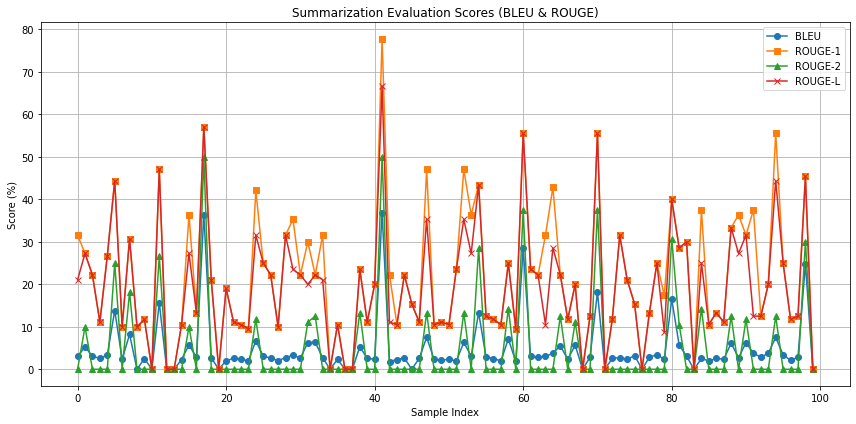

- **BLEU Score**
  - 대부분 0에 가깝고 간헐적 상승.
  - 즉, 예측 요약이 GT(정답)와 거의 겹치지 않음 → **어휘/구문 단위 불일치**.

- **ROUGE-1, 2, L**
  - ROUGE-1, L은 일부 지점에서 급상승하나 대부분 낮은 값.
  - ROUGE-2는 더 낮은 점수 분포 (n-gram 중복이 거의 없음).
  - → 모델이 **내용 압축은 되었으나 정확한 구문 재현은 부족**하다는 해석 가능.

---



### 6-4-3.🔍 BLUE /ROUGE 점수로 본 Summa 요약 (추출)

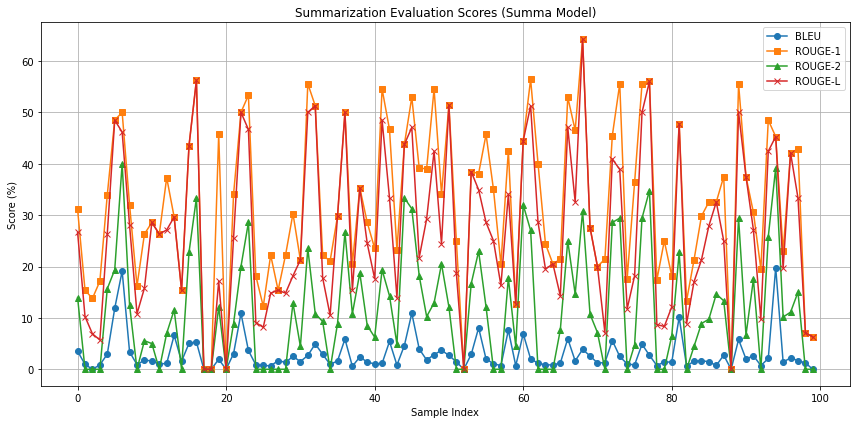

- **BLEU Score**
  - 여전히 낮지만 상대적으로 **고르게 2~6점 분포**.
  - 단어 단위 n-gram 매칭이 조금씩은 이루어지고 있음을 의미.

- **ROUGE-1, L**
  - 전반적으로 높은 스코어 유지.
  - 특히 ROUGE-L이 꾸준히 40~60%대를 유지하는 샘플이 많음 → **긴 문장 구조 단위의 재현력이 좋음**.

- **ROUGE-2**
  - n-gram 일치는 불규칙하지만 BLEU보다는 높음.
  - → **요약이 길면서도 문맥과 구조를 유지한 측면**에서 좋다고 해석 가능.

---

### 6-4-4.🔍 정보 보존 평가 (Keyword Coverage Evaluation)로 본 결론 요약

| 항목 | 평가 |
|------|------|
| 🔹 **Seq2Seq 요약** | 추상적 표현력은 있으나, **핵심 정보 보존에는 취약** |
| 🔹 **Summa 요약** | **정보 보존률 우수**, 그러나 문장 연결성이나 간결함 부족 가능 |
| 🔹 **키워드 Recall 기준 평가** | 기존 BLEU/ROUGE 점수에서 보지 못하던 **정보 함축력** 평가 가능 |
| 🔹 **결론** | Seq2Seq 모델은 **어휘 다양성은 높지만**, **정보 충실도는 낮음** → 개선 필요 |


### ✨ 결론 및 인사이트

| 요약 모델   | 잘하는 점                                        | 부족한 점                                      | 추천 사용 상황                                |
|-------------|--------------------------------------------------|------------------------------------------------|------------------------------------------------|
| **Seq2Seq** | 간단한 키워드 중심 요약 가능                    | 어휘 다양성, 원문 재현, 논리 구조 표현 부족     | 짧고 캐주얼한 요약 / 뉴스 제목 스타일 요약 등 |
| **Summa**   | 문장 구조, 정보 압축, 핵심문장 추출에 강함       | 단어 선택 일치율 낮음 (BLEU 낮음)              | 기사 요약, 보고서 요약 등 실무 활용 적합       |


# 7. Seq2Seq + Attention 모델 성능 향상을 위한 개선 전략

### ✅ 1. **어텐션 메커니즘 고도화**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Luong Attention** | dot-product 방식으로 효율성 향상 | 계산 속도 빠름, 간단한 구조 |
| **Multi-Head Attention** | 병렬 어텐션으로 다양한 시야 제공 | 문맥 해석력 강화 |
| **Coverage Mechanism** | 이미 본 토큰 중복 방지 | 중복 요약 감소, 요약 다양성 증가 |
| **Keyphrase-aware Attention** | 핵심어에 높은 가중치 부여 | 정보 보존력 향상 |
| **Copy Mechanism / Pointer Network** | 입력에서 단어 복사 허용 | OOV 대응, 사실성 강화 |

---

### ✅ 2. **임베딩 품질 향상**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Pre-trained Embedding** (GloVe, FastText 등) | 일반 언어 지식 반영 | 적은 데이터에도 표현력 향상 |
| **Fine-tuning Embedding** | 초기에는 freeze 후 점차 학습 허용 | 도메인 적응력 향상 |
| **Subword Embedding (e.g. BPE)** | 희귀 단어 분해 | OOV 문제 완화, 의미 표현력 강화 |

---

### ✅ 3. **모델 구조 개선**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Bidirectional Encoder** | 과거+미래 문맥 반영 | 더 깊은 의미 이해 가능 |
| **Stacked RNN (LSTM/GRU)** | 층 수 늘려 고차 정보 추출 | 추상화 수준 증가 |
| **Residual Connection + LayerNorm** | 깊은 네트워크 안정화 | 학습 속도와 안정성 개선 |

---

### ✅ 4. **학습 안정성 및 Regularization**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Dropout + Recurrent Dropout** | 과적합 방지 | 일반화 능력 향상 |
| **Gradient Clipping** | 폭발적 gradient 억제 | 안정적 학습 가능 |
| **Label Smoothing** | 확신 완화 → overfitting 방지 | generalization 향상 |
| **Learning Rate Scheduler** | val_loss 개선을 유도 | 효율적 학습 단계 조절 |

---

### ✅ 5. **Decoder 디코딩 전략**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Beam Search Decoding** | 여러 후보 중 최적 선택 | 더 자연스럽고 정확한 문장 생성 |
| **Length Normalization** | beam이 짧은 문장을 선호하는 편향 보정 | 균형 잡힌 요약 길이 유지 |
| **Top-k / Top-p Sampling** | 확률 기반 다양성 유도 | 창의적 표현 가능 (추상 요약에서 유용) |

---

### ✅ 6. **데이터 전처리 / 구성 개선**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **길이 제한 분석 후 필터링** | 너무 짧거나 긴 문장 제외 | 노이즈 감소, 효율적 학습 |
| **중복 제거 + 불용어 처리** | 정보 밀도 증가 | 학습 데이터 품질 개선 |
| **오타, 특수기호 정리** | 토큰화 품질 향상 | 임베딩 정확도 향상 |

---

### ✅ 7. **후처리 및 평가 안정화**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **정규화 처리 (소문자, 구두점)** | BLEU/ROUGE 안정성 향상 | 평가 일관성 확보 |
| **핵심어 포함 여부 검증** | 내용 보존 여부 확인 | 품질 보증 수단 |
| **요약 길이 조절 / clipping** | 너무 짧거나 긴 요약 방지 | 일관된 사용자 경험 제공 |

---

### ✅ 8. **Keyword 기반 평가 / 학습 보완 (추천)**

| 전략 | 설명 | 기대 효과 |
|------|------|-----------|
| **Keyword Inclusion Evaluation** | 핵심어 포함 여부 측정 | 정보 보존 측정에 적합 |
| **Abstractive Recall Metric** | 추상 요약 내 키워드 비율 측정 | 요약의 핵심 정보 보존율 평가 |
| **Keyword-aware Loss** | 키워드 포함 예측에 더 큰 loss 부여 | 정보 보존 향상, 키워드 누락 줄임 |

---

## 🔍 정리하면?

| 목표 | 주된 전략 |
|------|-----------|
| **정확도 향상** | 어텐션 고도화, pre-trained 임베딩, copy/coverage |
| **자연스러움** | Beam Search + length control, Bidirectional encoder |
| **학습 안정성** | Gradient Clipping, Dropout, Scheduler |
| **정보 보존** | Keyword-aware loss + 평가 지표 도입 |

---

### 🚀 추천 실험 우선순위

| 단계 | 구성 | 목적 |
|------|--------|------|
| ✅ Step 1 | `Bidirectional LSTM + Luong Attention` | 문맥 이해 강화 |
| ✅ Step 2 | `Pre-trained Embedding + Dropout` | 일반화 성능 향상 |
| ✅ Step 3 | `Beam Search + Coverage` | 출력 품질 + 정보 보존 |
| ✅ Step 4 | `Keyword-aware Loss + Recall Metric` | 핵심 정보 유지력 강화 |


# 8. 회고


### ✅ 배운 점 (What I Learned)

1. **Seq2Seq 모델과 어텐션 메커니즘의 구조와 원리**  
   - 기본적인 인코더-디코더 구조를 익혔고, 어텐션을 통해 디코더가 입력 시퀀스의 중요한 부분에 집중할 수 있도록 돕는 방식을 이해함.

2. **BLEU, ROUGE 외에도 다양한 평가 지표가 필요하다는 사실**  
   - 기존 정량 지표(BLEU, ROUGE)는 형식적인 유사도만 반영함 → **핵심 단어 포함 수**, **포함 비율**, **정보 보존 정도** 등을 함께 평가해야 실질적인 성능 확인 가능.

3. **데이터 전처리에서 통계적 기준의 중요성**  
   - 단순히 임의로 자르기보다는 IQR이나 Threshold 기반의 시각화를 통해 **데이터의 특성을 반영한 합리적 기준 설정** 가능함.

4. **추출 요약과 추상 요약의 개념적, 평가적 차이**  
   - 추출 요약은 정보 보존력은 높지만 부자연스럽고, 추상 요약은 표현이 자연스럽지만 정보 손실 위험이 존재함 → **두 방식의 조합이 현실적으로 가장 효과적일 수 있음.**

---

### ⚠️ 시행착오 (Challenges & Mistakes)


1. **데이터 인덱스 불일치로 인한 비교 실패**
- 전처리 및 샘플링 과정에서 **Seq2Seq 데이터와 Summa 데이터 간 인덱스가 달라짐**.
- 단순한 인덱스 기준 매칭은 무의미해졌고, 결과적으로 **텍스트 유사도 기반으로 matching 방식을 전환**해야 했음.

2. **Summa 모델은 전처리 없이 사용해야 함**
- Summa는 본질적으로 **비지도 학습 기반의 extractive 요약 모델**.
- 전처리를 적용하면 문장 구조가 무너져 **요약 품질이 급격히 저하**됨.
- → 반면, Seq2Seq은 전처리를 통해 불필요한 노이즈 제거가 필요했음.  
- **모델별 전처리 방식은 달라야 한다는 점**을 명확히 체득하게 된 경험.


### 😔 아쉬운 점 (What Could Be Improved)

1. **Beam Search 등의 디코딩 전략 실험 부족**  
   - 대부분 greedy decoding으로만 결과를 봤고, 다양한 디코딩 방식(beam, top-k, nucleus sampling)을 적용해보지 못한 점이 아쉬움.

2. **어텐션 가중치 시각화 미시도**  
   - 어텐션 매커니즘의 해석 가능성을 충분히 활용하지 못함 → attention weight matrix 시각화로 어떤 단어에 주목하는지 보여줄 수 있었음.

3. **추상 요약의 불안정성 보완 필요성**  
   - 일부 추상 요약 결과가 의미 없는 문장으로 나왔고, 이를 걸러낼 후처리 로직이나 `coverage`, `copy mechanism` 등 개선을 적용하지 못한 점.

---

### 💡 앞으로의 개선 방향

- Copy Mechanism과 Coverage 도입으로 정보 누락 및 중복 방지  
- Keyword-aware 평가 기준을 학습 과정에도 반영 (예: keyword loss)  
- Beam Search 기반의 디코딩으로 더 자연스러운 문장 생성 유도  

